## Sanketh Sequeira
## UIN: 679015531

# 🎾 ATP Tennis Match Analysis: Decoding the Data Behind the Aces

**What makes a tennis player win?** Is it raw talent, strategic serve placement, or perhaps knowing your opponent's weaknesses like the back of your racket? 

In this project, we dive deep into 33 years of ATP singles match data (1992–2024) to uncover patterns that would make even Federer raise an eyebrow. We're not just counting aces—we're engineering features, analyzing Elo trajectories, and building models that can predict match outcomes before the first serve.

### What's in Store:
- **Data Storytelling:** From raw match logs to a feature-rich dataset (spoiler: it's more complex than it sounds)
- **The Elo Journey:** Tracking how player ratings evolve over surfaces and time—because not all clay courts are created equal
- **Visual Discoveries:** Surface specialists, age curves, and why some players peak like fine wine while others... well, they peak
- **Prediction Power:** Can machines learn to predict tennis matches? (Spoiler: they're getting pretty good at it)

### Our Mission:
Build predictive models that understand tennis better than a casual observer (and hopefully better than that friend who picks winners based on "vibes").

*Let's serve up some data science!* 🎾

# Changes since the proposal
We swapped the stock project for ATP match analysis after chatting with the professor. Now we’re building a cleaned dataset (1992–2024) with ELOs, doing quick EDA (2nd‑serve impact, surface specialists, yearly top ELO, top‑5 ELO trends) and training models to predict match winners.

# Dataset Construction:
We build final_data by taking each match (winner vs loser) and converting raw match fields into player‑pair difference features (PLAYER_1 − PLAYER_2).
This yields direct comparative predictors for modeling match outcomes.
## Key Derived Columns:
- *Ranking/Points:* ATP_POINT_DIFF = winner_rank_points - loser_rank_points, ATP_RANK_DIFF = winner_rank - loser_rank.
- *Demographics:* AGE_DIFF, HEIGHT_DIFF.
- *Match Context:* BEST_OF, DRAW_SIZE.
- *Head‑to‑Head:* H2H_DIFF and H2H_SURFACE_DIFF computed from prior matches (overall and surface‑specific).
- *Rolling Performance:* For k ∈ {3,5,10,20,50,100,200,300,2000}, percent‑based serve/defense differences (e.g., P_ACE_LAST_k_DIFF, P_1ST_WON_LAST_k_DIFF) are computed with per‑player rolling deques and sampled before each match.
- *Recent Form:* WIN_LAST_k_DIFF = recent win‑rate difference using rolling windows (k ∈ {3,5,10,20,50,100,200,300,2000}).
- *ELO:* Merged atp_elo_ratings.csv (name normalization) to compute ELO_DIFF and SURF_ELO_DIFF (surface‑specific ELO when available).

## Import packages here

In [1]:
import pandas as pd

## Step 1: Assembling the Time Machine

Our journey starts with 33 years of ATP match data (1992-2024). That's over three decades of serves, volleys, and occasional dramatic upsets. We'll combine match files from each year into one unified dataset—think of it as creating a comprehensive tennis history book, one chapter at a time.

*Fun fact: We're processing over 90,000 matches. That's a lot of tennis!*

In [2]:
all_data = pd.DataFrame()
for year in range(1992, 2025):
    file = "./Data/SingleMatches/atp_matches_"+str(year)+'.csv'

    year_data = pd.read_csv(file)

    all_data = pd.concat([all_data, year_data], axis = 0)

all_data

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,1992-339,Adelaide,Hard,32,A,19911230,1,101964,1.0,NaN,...,34.0,23.0,6.0,9.0,0.0,3.0,16.0,NaN,80.0,NaN
1,1992-339,Adelaide,Hard,32,A,19911230,2,101924,NaN,NaN,...,65.0,39.0,9.0,10.0,8.0,12.0,65.0,NaN,63.0,NaN
2,1992-339,Adelaide,Hard,32,A,19911230,3,101195,NaN,NaN,...,68.0,45.0,22.0,16.0,8.0,12.0,62.0,NaN,730.0,NaN
3,1992-339,Adelaide,Hard,32,A,19911230,4,101820,NaN,NaN,...,49.0,34.0,16.0,14.0,1.0,4.0,60.0,NaN,42.0,NaN
4,1992-339,Adelaide,Hard,32,A,19911230,5,100870,NaN,NaN,...,95.0,65.0,15.0,18.0,5.0,7.0,68.0,NaN,32.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3071,2024-M-DC-2024-WG2-PO-URU-MDA-01,Davis Cup WG2 PO: URU vs MDA,Clay,4,D,20240203,5,212051,NaN,NaN,...,30.0,17.0,7.0,6.0,8.0,14.0,1109.0,8.0,740.0,34.0
3072,2024-M-DC-2024-WG2-PO-VIE-RSA-01,Davis Cup WG2 PO: VIE vs RSA,Hard,4,D,20240202,1,122533,NaN,NaN,...,41.0,25.0,6.0,9.0,1.0,4.0,554.0,67.0,748.0,32.0
3073,2024-M-DC-2024-WG2-PO-VIE-RSA-01,Davis Cup WG2 PO: VIE vs RSA,Hard,4,D,20240202,2,144748,NaN,NaN,...,51.0,25.0,7.0,11.0,5.0,12.0,416.0,109.0,NaN,NaN
3074,2024-M-DC-2024-WG2-PO-VIE-RSA-01,Davis Cup WG2 PO: VIE vs RSA,Hard,4,D,20240202,4,122533,NaN,NaN,...,51.0,32.0,17.0,14.0,5.0,9.0,554.0,67.0,416.0,109.0


In [3]:
all_data.columns

Index(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'winner_id', 'winner_seed', 'winner_entry',
       'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age',
       'loser_id', 'loser_seed', 'loser_entry', 'loser_name', 'loser_hand',
       'loser_ht', 'loser_ioc', 'loser_age', 'score', 'best_of', 'round',
       'minutes', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon',
       'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt',
       'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced',
       'winner_rank', 'winner_rank_points', 'loser_rank', 'loser_rank_points'],
      dtype='object')

## Step 2: Quality Control (The Boring but Essential Part)

Real-world data is messy. Some matches have incomplete stats, missing player info, or gaps that would make any data scientist cry. We filter out rows with missing critical information—because you can't predict a match if you don't know who's playing or what surface they're on.

*After filtering, we're left with ~92,000 clean matches. Quality over quantity!*

In [4]:
filtered_data = all_data.dropna(subset=[
        'winner_id', 'winner_name', 'loser_id', 'loser_name', 'winner_ht', 'winner_age', 'loser_ht', 'loser_age',
       'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms',
        'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt', 'l_1stIn', 'l_1stWon', 
        'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced', 'winner_rank', 'winner_rank_points',
        'loser_rank', 'loser_rank_points', 'surface'])

filtered_data = filtered_data.reset_index(drop=True)            #starts index back from zero

filtered_data

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,1992-301,Auckland,Hard,32,A,19920106,1,101797,NaN,NaN,...,50.0,40.0,24.0,12.0,4.0,4.0,110.0,333.0,8.0,1599.0
1,1992-301,Auckland,Hard,32,A,19920106,2,101205,NaN,NaN,...,58.0,28.0,10.0,9.0,5.0,8.0,78.0,462.0,101.0,378.0
2,1992-301,Auckland,Hard,32,A,19920106,3,101368,NaN,NaN,...,28.0,19.0,11.0,9.0,4.0,8.0,82.0,436.0,1059.0,3.0
3,1992-301,Auckland,Hard,32,A,19920106,4,100772,NaN,WC,...,46.0,31.0,16.0,12.0,3.0,6.0,171.0,201.0,52.0,607.0
4,1992-301,Auckland,Hard,32,A,19920106,5,101532,4.0,NaN,...,57.0,39.0,21.0,14.0,9.0,12.0,30.0,837.0,99.0,383.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92328,2024-M-DC-2024-WG2-PO-TOG-INA-01,Davis Cup WG2 PO: TOG vs INA,Hard,4,D,20240203,4,207134,NaN,NaN,...,35.0,19.0,5.0,8.0,5.0,9.0,569.0,64.0,819.0,24.0
92329,2024-M-DC-2024-WG2-PO-TUN-CRC-01,Davis Cup WG2 PO: TUN vs CRC,Hard,4,D,20240202,1,121411,NaN,NaN,...,30.0,17.0,9.0,8.0,2.0,5.0,279.0,205.0,900.0,18.0
92330,2024-M-DC-2024-WG2-PO-URU-MDA-01,Davis Cup WG2 PO: URU vs MDA,Clay,4,D,20240203,1,208364,NaN,NaN,...,52.0,24.0,18.0,12.0,8.0,16.0,616.0,55.0,740.0,34.0
92331,2024-M-DC-2024-WG2-PO-URU-MDA-01,Davis Cup WG2 PO: URU vs MDA,Clay,4,D,20240203,4,105430,NaN,NaN,...,66.0,33.0,6.0,8.0,6.0,11.0,136.0,489.0,616.0,55.0


## Step 3: The Art of Feature Engineering

Here's where the magic happens. We're not just using raw match statistics—we're creating *comparative features* that capture the relative strengths and weaknesses between two players at the moment they face off.

**The Philosophy:** Instead of asking "How good is Player A?", we ask "How much better is Player A than Player B?" This difference-focused approach is what makes our features predictive.

We'll calculate:
- **Basic differences:** Ranking, age, height (because sometimes every centimeter counts)
- **Head-to-head records:** Historical matchups matter (just ask Federer vs Nadal)
- **Recent form:** Last 3, 5, 10... even 2000 matches (okay, that last one might be overkill)
- **Surface-specific stats:** Because playing on clay requires different skills than grass

In [5]:
final_data = pd.DataFrame()
final_data['WINNER_ID'] = filtered_data['winner_id']
final_data['WINNER_NAME'] = filtered_data['winner_name']
final_data['LOSER_ID'] = filtered_data['loser_id']
final_data['LOSER_NAME'] = filtered_data['loser_name']
final_data['ATP_POINT_DIFF'] = filtered_data['winner_rank_points'] - filtered_data['loser_rank_points']
final_data['ATP_RANK_DIFF'] = filtered_data['winner_rank'] - filtered_data['loser_rank']
final_data['AGE_DIFF'] = filtered_data['winner_age'] - filtered_data['loser_age']
final_data['HEIGHT_DIFF'] = filtered_data['winner_ht'] - filtered_data['loser_ht']
final_data['BEST_OF'] = filtered_data['best_of']
final_data['DRAW_SIZE'] = filtered_data['draw_size']

final_data

,WINNER_ID,WINNER_NAME,LOSER_ID,LOSER_NAME,ATP_POINT_DIFF,ATP_RANK_DIFF,AGE_DIFF,HEIGHT_DIFF,BEST_OF,DRAW_SIZE
0,101797,Jacco Eltingh,101120,Karel Novacek,-1266.0,102.0,-5.4,-2.0,3,32
1,101205,Grant Connell,101767,Lars Jonsson,84.0,-23.0,4.6,-3.0,3,32
2,101368,Christian Miniussi,102536,James Greenhalgh,433.0,-977.0,7.7,2.0,3,32
3,100772,Kelly Evernden,101746,Renzo Furlan,-406.0,119.0,8.6,0.0,3,32
4,101532,Francisco Clavet,101119,Marian Vajda,454.0,-69.0,-3.5,10.0,3,32
...,...,...,...,...,...,...,...,...,...,...
92328,207134,Fitriadi M Rifqi,133933,Thomas Yaka Kofi Setodji,40.0,-250.0,-3.2,-8.0,3,4
92329,121411,Moez Echargui,132374,Jesse Flores,187.0,-621.0,2.2,-10.0,3,4
92330,208364,Franco Roncadelli,209943,Ilya Snitari,21.0,-124.0,2.1,-3.0,3,4
92331,105430,Radu Albot,208364,Franco Roncadelli,434.0,-480.0,10.3,-10.0,3,4


### Feature Engineering: Head-to-Head Records

*Some rivalries transcend time.* The H2H (head-to-head) record captures the psychological and strategic dynamics between two players. Some players just have others' numbers—Federer dominated Murray overall, but struggled against Nadal on clay.

We compute two features:
- **H2H_DIFF:** Overall head-to-head win difference (how many more times has Player A beaten Player B?)
- **H2H_SURFACE_DIFF:** Surface-specific H2H difference (because Nadal on clay is a different beast than Nadal on grass)

*Implementation note: We iterate chronologically to ensure we only use historical data—no peeking into the future!*


In [6]:
# Calculate H2H and H2H on that surface
from collections import defaultdict
from tqdm import tqdm

h2h_surface_dict = defaultdict(lambda: defaultdict(int))
h2h_dict = defaultdict(int)
total_h2h_surface = []
total_h2h = []

for idx, (w_id, l_id, surface) in enumerate(tqdm(zip(filtered_data['winner_id'],
                                                     filtered_data['loser_id'],
                                                     filtered_data['surface']),
                                                 total=len(filtered_data))):
    wins = h2h_dict[(w_id, l_id)]
    loses = h2h_dict[(l_id, w_id)]

    wins_surface = h2h_surface_dict[surface][(w_id, l_id)]
    loses_surface = h2h_surface_dict[surface][(l_id, w_id)]

    total_h2h.append(wins - loses)
    total_h2h_surface.append(wins_surface - loses_surface)

    h2h_dict[(w_id, l_id)] += 1
    h2h_surface_dict[surface][(w_id, l_id)] += 1

final_data["H2H_DIFF"] = total_h2h
final_data["H2H_SURFACE_DIFF"] = total_h2h_surface

final_data


100%|██████████| 92333/92333 [00:00<00:00, 399888.35it/s]


,WINNER_ID,WINNER_NAME,LOSER_ID,LOSER_NAME,ATP_POINT_DIFF,ATP_RANK_DIFF,AGE_DIFF,HEIGHT_DIFF,BEST_OF,DRAW_SIZE,H2H_DIFF,H2H_SURFACE_DIFF
0,101797,Jacco Eltingh,101120,Karel Novacek,-1266.0,102.0,-5.4,-2.0,3,32,0,0
1,101205,Grant Connell,101767,Lars Jonsson,84.0,-23.0,4.6,-3.0,3,32,0,0
2,101368,Christian Miniussi,102536,James Greenhalgh,433.0,-977.0,7.7,2.0,3,32,0,0
3,100772,Kelly Evernden,101746,Renzo Furlan,-406.0,119.0,8.6,0.0,3,32,0,0
4,101532,Francisco Clavet,101119,Marian Vajda,454.0,-69.0,-3.5,10.0,3,32,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
92328,207134,Fitriadi M Rifqi,133933,Thomas Yaka Kofi Setodji,40.0,-250.0,-3.2,-8.0,3,4,0,0
92329,121411,Moez Echargui,132374,Jesse Flores,187.0,-621.0,2.2,-10.0,3,4,0,0
92330,208364,Franco Roncadelli,209943,Ilya Snitari,21.0,-124.0,2.1,-3.0,3,4,0,0
92331,105430,Radu Albot,208364,Franco Roncadelli,434.0,-480.0,10.3,-10.0,3,4,0,0


### Feature Engineering: Rolling Performance Windows

*Recent form matters.* A player coming off a hot streak is different from one in a slump. We track rolling averages across multiple window sizes (3, 5, 10, 20, 50, 100, 200, 300, and yes, 2000 matches—because why not?) for:

- **Ace percentage:** That killer serve
- **Double fault rate:** Those costly mistakes
- **First serve statistics:** Accuracy and win rate
- **Second serve performance:** The recovery game
- **Break point defense:** Clutch performance under pressure

**The Technical Bit:** We use rolling deques to efficiently track the last k matches per player, compute pre-match averages (no data leakage!), then update after each match. This gives us a real-time snapshot of each player's form heading into their match.

*Why multiple windows? Short-term (k=3) captures hot streaks, while long-term (k=2000) captures career form.*


In [7]:
from collections import defaultdict, deque
import numpy as np


def smean(seq):
    """Safe mean -> 0.0 when empty."""
    return float(np.mean(seq)) if seq else 0.0

all_data_filtered = filtered_data.sort_values(
    ['tourney_date', 'match_num'], kind='mergesort'
).reset_index(drop=True)


for k in [3, 5, 10, 20, 50, 100, 200, 300, 2000]:
  
    last_k_matches = defaultdict(lambda: defaultdict(lambda: deque(maxlen=k)))

    
    p_ace_k      = []
    p_df_k       = []
    p_1stIn_k    = []
    p_1stWon_k   = []
    p_2ndWon_k   = []
    p_bpSaved_k  = []

   
    for row in all_data_filtered.itertuples(index=False):
        
        w_id, l_id = row.winner_id, row.loser_id

       
        w_ace,   l_ace   = row.w_ace,   row.l_ace
        w_df,    l_df    = row.w_df,    row.l_df
        w_svpt,  l_svpt  = row.w_svpt,  row.l_svpt
        w_1stIn, l_1stIn = row.w_1stIn, row.l_1stIn
        w_1stWon,l_1stWon= row.w_1stWon,row.l_1stWon
        w_2ndWon,l_2ndWon= row.w_2ndWon,row.l_2ndWon
        w_SvGms,l_SvGms  = row.w_SvGms, row.l_SvGms
        w_bpSaved,l_bpSaved = row.w_bpSaved, row.l_bpSaved
        w_bpFaced,l_bpFaced = row.w_bpFaced, row.l_bpFaced

        
        p_ace_k.append( smean(last_k_matches[w_id]["p_ace"]) - smean(last_k_matches[l_id]["p_ace"]))
        p_df_k.append( smean(last_k_matches[w_id]["p_df"]) - smean(last_k_matches[l_id]["p_df"]))
        p_1stIn_k.append( smean(last_k_matches[w_id]["p_1stIn"]) - smean(last_k_matches[l_id]["p_1stIn"]))
        p_1stWon_k.append( smean(last_k_matches[w_id]["p_1stWon"]) - smean(last_k_matches[l_id]["p_1stWon"]))
        p_2ndWon_k.append( smean(last_k_matches[w_id]["p_2ndWon"]) - smean(last_k_matches[l_id]["p_2ndWon"]))
        p_bpSaved_k.append( smean(last_k_matches[w_id]["p_bpSaved"]) - smean(last_k_matches[l_id]["p_bpSaved"]))

        
        # Winner percentages
        if w_svpt != 0:
            last_k_matches[w_id]["p_ace"].append(100.0 * (w_ace / w_svpt))
            last_k_matches[w_id]["p_df"].append(100.0 * (w_df / w_svpt))
            last_k_matches[w_id]["p_1stIn"].append(100.0 * (w_1stIn / w_svpt))
        if w_1stIn != 0:
            last_k_matches[w_id]["p_1stWon"].append(100.0 * (w_1stWon / w_1stIn))
        if (w_svpt - w_1stIn) != 0:
            last_k_matches[w_id]["p_2ndWon"].append(100.0 * (w_2ndWon / (w_svpt - w_1stIn)))
        if w_bpFaced != 0:
            last_k_matches[w_id]["p_bpSaved"].append(100.0 * (w_bpSaved / w_bpFaced))

        # Loser percentages
        if l_svpt != 0:
            last_k_matches[l_id]["p_ace"].append(100.0 * (l_ace / l_svpt))
            last_k_matches[l_id]["p_df"].append(100.0 * (l_df / l_svpt))
            last_k_matches[l_id]["p_1stIn"].append(100.0 * (l_1stIn / l_svpt))
        if l_1stIn != 0:
            last_k_matches[l_id]["p_1stWon"].append(100.0 * (l_1stWon / l_1stIn))
        if (l_svpt - l_1stIn) != 0:
            last_k_matches[l_id]["p_2ndWon"].append(100.0 * (l_2ndWon / (l_svpt - l_1stIn)))
        if l_bpFaced != 0:
            last_k_matches[l_id]["p_bpSaved"].append(100.0 * (l_bpSaved / l_bpFaced))

    final_data[f"P_ACE_LAST_{k}_DIFF"]      = p_ace_k
    final_data[f"P_DF_LAST_{k}_DIFF"]       = p_df_k
    final_data[f"P_1ST_IN_LAST_{k}_DIFF"]   = p_1stIn_k
    final_data[f"P_1ST_WON_LAST_{k}_DIFF"]  = p_1stWon_k
    final_data[f"P_2ND_WON_LAST_{k}_DIFF"]  = p_2ndWon_k
    final_data[f"P_BP_SAVED_LAST_{k}_DIFF"] = p_bpSaved_k


In [8]:
final_data

,WINNER_ID,WINNER_NAME,LOSER_ID,LOSER_NAME,ATP_POINT_DIFF,ATP_RANK_DIFF,AGE_DIFF,HEIGHT_DIFF,BEST_OF,DRAW_SIZE,...,P_1ST_IN_LAST_300_DIFF,P_1ST_WON_LAST_300_DIFF,P_2ND_WON_LAST_300_DIFF,P_BP_SAVED_LAST_300_DIFF,P_ACE_LAST_2000_DIFF,P_DF_LAST_2000_DIFF,P_1ST_IN_LAST_2000_DIFF,P_1ST_WON_LAST_2000_DIFF,P_2ND_WON_LAST_2000_DIFF,P_BP_SAVED_LAST_2000_DIFF
0,101797,Jacco Eltingh,101120,Karel Novacek,-1266.0,102.0,-5.4,-2.0,3,32,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,101205,Grant Connell,101767,Lars Jonsson,84.0,-23.0,4.6,-3.0,3,32,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,101368,Christian Miniussi,102536,James Greenhalgh,433.0,-977.0,7.7,2.0,3,32,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,100772,Kelly Evernden,101746,Renzo Furlan,-406.0,119.0,8.6,0.0,3,32,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,101532,Francisco Clavet,101119,Marian Vajda,454.0,-69.0,-3.5,10.0,3,32,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92328,207134,Fitriadi M Rifqi,133933,Thomas Yaka Kofi Setodji,40.0,-250.0,-3.2,-8.0,3,4,...,6.622831,-13.411429,0.291809,2.718619,-4.685967,-1.811381,6.622831,-13.411429,0.291809,2.718619
92329,121411,Moez Echargui,132374,Jesse Flores,187.0,-621.0,2.2,-10.0,3,4,...,1.269346,1.862017,2.029024,0.848561,-3.006825,0.054561,1.269346,1.862017,2.029024,0.848561
92330,208364,Franco Roncadelli,209943,Ilya Snitari,21.0,-124.0,2.1,-3.0,3,4,...,0.126691,-5.910131,-1.772576,5.050027,-1.635691,-0.493191,0.126691,-5.910131,-1.772576,5.050027
92331,105430,Radu Albot,208364,Franco Roncadelli,434.0,-480.0,10.3,-10.0,3,4,...,5.002503,0.485732,6.268410,-5.179438,1.322220,-1.550933,5.002503,0.485732,6.268410,-5.179438


### Recent Form (Win Rate) Feature Calculation

For each player, we tracked their win rate over the last *k* matches where *k* ∈ {3, 5, 10, 25, 50, 100}.  
Before every match, we computed the difference in recent win percentages between PLAYER_1 and PLAYER_2, then updated the rolling records (1 = win, 0 = loss).  
Finally, a `RESULT` column was added as 1 since each row represents the winner’s perspective.


In [9]:
from collections import defaultdict, deque
import numpy as np

for k in [3, 5, 10, 25, 50, 100]:
    recent_results = defaultdict(lambda: deque(maxlen=k))
    win_last_k = []

    for row in filtered_data.itertuples(index=False):
        w_id, l_id = row.winner_id, row.loser_id

        # Past win % before current match
        w_winrate = np.mean(recent_results[w_id]) if recent_results[w_id] else 0
        l_winrate = np.mean(recent_results[l_id]) if recent_results[l_id] else 0
        win_last_k.append(w_winrate - l_winrate)

        # Update running results (1 = win, 0 = loss)
        recent_results[w_id].append(1)
        recent_results[l_id].append(0)

    final_data[f'WIN_LAST_{k}_DIFF'] = win_last_k
    
final_data['RESULT'] = 1  # winner always 1 since each row is from winner’s perspective



In [10]:
final_data.columns

Index(['WINNER_ID', 'WINNER_NAME', 'LOSER_ID', 'LOSER_NAME', 'ATP_POINT_DIFF',
       'ATP_RANK_DIFF', 'AGE_DIFF', 'HEIGHT_DIFF', 'BEST_OF', 'DRAW_SIZE',
       'H2H_DIFF', 'H2H_SURFACE_DIFF', 'P_ACE_LAST_3_DIFF', 'P_DF_LAST_3_DIFF',
       'P_1ST_IN_LAST_3_DIFF', 'P_1ST_WON_LAST_3_DIFF',
       'P_2ND_WON_LAST_3_DIFF', 'P_BP_SAVED_LAST_3_DIFF', 'P_ACE_LAST_5_DIFF',
       'P_DF_LAST_5_DIFF', 'P_1ST_IN_LAST_5_DIFF', 'P_1ST_WON_LAST_5_DIFF',
       'P_2ND_WON_LAST_5_DIFF', 'P_BP_SAVED_LAST_5_DIFF', 'P_ACE_LAST_10_DIFF',
       'P_DF_LAST_10_DIFF', 'P_1ST_IN_LAST_10_DIFF', 'P_1ST_WON_LAST_10_DIFF',
       'P_2ND_WON_LAST_10_DIFF', 'P_BP_SAVED_LAST_10_DIFF',
       'P_ACE_LAST_20_DIFF', 'P_DF_LAST_20_DIFF', 'P_1ST_IN_LAST_20_DIFF',
       'P_1ST_WON_LAST_20_DIFF', 'P_2ND_WON_LAST_20_DIFF',
       'P_BP_SAVED_LAST_20_DIFF', 'P_ACE_LAST_50_DIFF', 'P_DF_LAST_50_DIFF',
       'P_1ST_IN_LAST_50_DIFF', 'P_1ST_WON_LAST_50_DIFF',
       'P_2ND_WON_LAST_50_DIFF', 'P_BP_SAVED_LAST_50_DIFF',
       

## Neeraj VP
## UIN: 676501525

##  Feature Description 
---

###  Basic Match & Ranking Differences
| Column | Description |
|---------|--------------|
| **ATP_POINT_DIFF** | Difference in ATP ranking points between PLAYER_1 and PLAYER_2 *(PLAYER_1 − PLAYER_2)*. |
| **ATP_RANK_DIFF** | Difference in ATP ranking positions *(PLAYER_1 − PLAYER_2)* — lower means better rank. |
| **AGE_DIFF** | Difference in age between PLAYER_1 and PLAYER_2 (in years). |
| **HEIGHT_DIFF** | Height difference between PLAYER_1 and PLAYER_2 (in cm). |
| **BEST_OF** | Number of sets played in the match (e.g., 3 or 5). |
| **DRAW_SIZE** | Tournament draw size (e.g., 32, 64, 128 players). |

---

###  Head-to-Head Performance
| Column | Description |
|---------|--------------|
| **H2H_DIFF** | Overall win–loss record difference between PLAYER_1 and PLAYER_2 before this match. |
| **H2H_SURFACE_DIFF** | Win–loss difference between PLAYER_1 and PLAYER_2 *on the same surface* (Hard/Clay/Grass) before this match. |

---

###  Serve & Performance Statistics (Rolling Windows)
Each feature represents the **difference** in averages between PLAYER_1 and PLAYER_2 over the **last *k* matches**.

| Category | Example Columns | Description |
|-----------|------------------|--------------|
| **Aces** | `P_ACE_LAST_k_DIFF` | Difference in % of points won by aces in the last *k* matches. |
| **Double Faults** | `P_DF_LAST_k_DIFF` | Difference in % of double faults made in the last *k* matches. |
| **First Serve In** | `P_1ST_IN_LAST_k_DIFF` | Difference in % of first serves successfully landed in play. |
| **First Serve Won** | `P_1ST_WON_LAST_k_DIFF` | Difference in % of points won on first serve. |
| **Second Serve Won** | `P_2ND_WON_LAST_k_DIFF` | Difference in % of points won on second serve. |
| **Break Points Saved** | `P_BP_SAVED_LAST_k_DIFF` | Difference in % of break points saved (defensive success under pressure). |

Where *k ∈ {3, 5, 10, 20, 50, 100, 200, 300, 2000}* — representing the rolling window size.

---

### Form / Momentum Features
| Column | Description |
|---------|--------------|
| **WIN_LAST_3_DIFF** | Difference in win rate between PLAYER_1 and PLAYER_2 over their last 3 matches. |
| **WIN_LAST_5_DIFF** | Difference in win rate over last 5 matches. |
| **WIN_LAST_10_DIFF** | Difference in win rate over last 10 matches. |
| **WIN_LAST_25_DIFF** | Difference in win rate over last 25 matches. |
| **WIN_LAST_50_DIFF** | Difference in win rate over last 50 matches. |
| **WIN_LAST_100_DIFF** | Difference in win rate over last 100 matches. |

These features capture short-term and long-term momentum or player form.

---

###  Target Variable
| Column | Description |
|---------|--------------|
| **RESULT** | Match outcome label from PLAYER_1’s perspective — `1` if PLAYER_1 won, `0` if lost (after balancing). Always `1` in the original winner-only dataset. |

---



In [11]:
final_data.head()

,WINNER_ID,WINNER_NAME,LOSER_ID,LOSER_NAME,ATP_POINT_DIFF,ATP_RANK_DIFF,AGE_DIFF,HEIGHT_DIFF,BEST_OF,DRAW_SIZE,...,P_1ST_WON_LAST_2000_DIFF,P_2ND_WON_LAST_2000_DIFF,P_BP_SAVED_LAST_2000_DIFF,WIN_LAST_3_DIFF,WIN_LAST_5_DIFF,WIN_LAST_10_DIFF,WIN_LAST_25_DIFF,WIN_LAST_50_DIFF,WIN_LAST_100_DIFF,RESULT
0,101797,Jacco Eltingh,101120,Karel Novacek,-1266.0,102.0,-5.4,-2.0,3,32,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,101205,Grant Connell,101767,Lars Jonsson,84.0,-23.0,4.6,-3.0,3,32,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,101368,Christian Miniussi,102536,James Greenhalgh,433.0,-977.0,7.7,2.0,3,32,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,100772,Kelly Evernden,101746,Renzo Furlan,-406.0,119.0,8.6,0.0,3,32,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,101532,Francisco Clavet,101119,Marian Vajda,454.0,-69.0,-3.5,10.0,3,32,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [12]:
import pandas as pd, numpy as np, unicodedata

def norm_name(s):
    if pd.isna(s): return s
    s = unicodedata.normalize("NFKD", str(s))
    s = "".join(ch for ch in s if not unicodedata.combining(ch))
    s = s.lower().strip().replace(".", "").replace("-", " ")
    while "  " in s: s = s.replace("  ", " ")
    return s


elo = pd.read_csv("atp_elo_ratings.csv")
elo.columns = [c.strip().lower().replace(" ", "_") for c in elo.columns]
elo = elo[["player","elo","helo","celo","gelo"]].dropna(subset=["player"]).drop_duplicates("player")
elo["player_key"] = elo["player"].map(norm_name)


df = final_data.copy()
if "WINNER_NAME" not in df or "LOSER_NAME" not in df:
    raise KeyError("final_data must include WINNER_NAME and LOSER_NAME")
df["WINNER_KEY"] = df.get("WINNER_KEY", df["WINNER_NAME"].map(norm_name))
df["LOSER_KEY"]  = df.get("LOSER_KEY",  df["LOSER_NAME"].map(norm_name))


if "surface" not in df and "filtered_data" in globals() and "surface" in filtered_data.columns:
    df["surface"] = filtered_data["surface"]


need_cols = {"w_elo","l_elo","w_helo","l_helo","w_celo","l_celo","w_gelo","l_gelo"}
if not need_cols.issubset(df.columns):
    w = elo.add_prefix("w_") 
    l = elo.add_prefix("l_")
    df = df.merge(w, left_on="WINNER_KEY", right_on="w_player_key", how="left") \
           .merge(l, left_on="LOSER_KEY",  right_on="l_player_key",  how="left")


df["ELO_DIFF"] = df["w_elo"] - df["l_elo"]

if "surface" in df.columns:
    s = df["surface"].str.lower().fillna("")
    is_h, is_c, is_g = s.str.startswith("h"), s.str.startswith("c"), s.str.startswith("g")
    w_surf = np.select([is_h,            is_c,            is_g           ],
                       [df["w_helo"],    df["w_celo"],    df["w_gelo"]   ],
                       default=df["w_elo"])
    l_surf = np.select([is_h,            is_c,            is_g           ],
                       [df["l_helo"],    df["l_celo"],    df["l_gelo"]   ],
                       default=df["l_elo"])
    df["SURF_ELO_DIFF"] = w_surf - l_surf
else:
    df["SURF_ELO_DIFF"] = np.nan


if "RESULT" in df.columns:
    cols = df.columns.tolist()
    for c in ["ELO_DIFF","SURF_ELO_DIFF"]:
        if c in cols: cols.remove(c)
    ridx = cols.index("RESULT")
    df = df[cols[:ridx] + ["ELO_DIFF","SURF_ELO_DIFF"] + cols[ridx:]]

final_data = df



In [13]:
final_data.columns

Index(['WINNER_ID', 'WINNER_NAME', 'LOSER_ID', 'LOSER_NAME', 'ATP_POINT_DIFF',
       'ATP_RANK_DIFF', 'AGE_DIFF', 'HEIGHT_DIFF', 'BEST_OF', 'DRAW_SIZE',
       'H2H_DIFF', 'H2H_SURFACE_DIFF', 'P_ACE_LAST_3_DIFF', 'P_DF_LAST_3_DIFF',
       'P_1ST_IN_LAST_3_DIFF', 'P_1ST_WON_LAST_3_DIFF',
       'P_2ND_WON_LAST_3_DIFF', 'P_BP_SAVED_LAST_3_DIFF', 'P_ACE_LAST_5_DIFF',
       'P_DF_LAST_5_DIFF', 'P_1ST_IN_LAST_5_DIFF', 'P_1ST_WON_LAST_5_DIFF',
       'P_2ND_WON_LAST_5_DIFF', 'P_BP_SAVED_LAST_5_DIFF', 'P_ACE_LAST_10_DIFF',
       'P_DF_LAST_10_DIFF', 'P_1ST_IN_LAST_10_DIFF', 'P_1ST_WON_LAST_10_DIFF',
       'P_2ND_WON_LAST_10_DIFF', 'P_BP_SAVED_LAST_10_DIFF',
       'P_ACE_LAST_20_DIFF', 'P_DF_LAST_20_DIFF', 'P_1ST_IN_LAST_20_DIFF',
       'P_1ST_WON_LAST_20_DIFF', 'P_2ND_WON_LAST_20_DIFF',
       'P_BP_SAVED_LAST_20_DIFF', 'P_ACE_LAST_50_DIFF', 'P_DF_LAST_50_DIFF',
       'P_1ST_IN_LAST_50_DIFF', 'P_1ST_WON_LAST_50_DIFF',
       'P_2ND_WON_LAST_50_DIFF', 'P_BP_SAVED_LAST_50_DIFF',
       

## Example: Viewing Elo Data

In [14]:
carlos_matches = final_data[
    (final_data["WINNER_NAME"].str.contains("Carlos Alcaraz", case=False, na=False)) |
    (final_data["LOSER_NAME"].str.contains("Carlos Alcaraz", case=False, na=False))
]

carlos_matches.sample(5, random_state=42)


,WINNER_ID,WINNER_NAME,LOSER_ID,LOSER_NAME,ATP_POINT_DIFF,ATP_RANK_DIFF,AGE_DIFF,HEIGHT_DIFF,BEST_OF,DRAW_SIZE,...,w_helo,w_celo,w_gelo,w_player_key,l_player,l_elo,l_helo,l_celo,l_gelo,l_player_key
86453,208029,Holger Rune,207989,Carlos Alcaraz,-4739.0,17.0,0.1,5.0,3,64,...,1874.5,1878.7,1763.4,holger rune,Carlos Alcaraz,2268.4,2178.3,2214.5,2137.6,carlos alcaraz
86973,207989,Carlos Alcaraz,126523,Bernabe Zapata Miralles,6028.0,-72.0,-6.3,0.0,3,32,...,2178.3,2214.5,2137.6,carlos alcaraz,Bernabe Zapata Miralles,1433.4,1390.2,1419.9,1433.6,bernabe zapata miralles
92153,207989,Carlos Alcaraz,126094,Andrey Rublev,3050.0,-5.0,-5.5,-5.0,3,8,...,2178.3,2214.5,2137.6,carlos alcaraz,Andrey Rublev,1875.2,1831.3,1845.8,1787.1,andrey rublev
90893,207733,Jack Draper,207989,Carlos Alcaraz,-7209.0,29.0,1.3,10.0,3,32,...,1890.1,1816.6,1753.5,jack draper,Carlos Alcaraz,2268.4,2178.3,2214.5,2137.6,carlos alcaraz
84598,207989,Carlos Alcaraz,200175,Miomir Kecmanovic,1358.0,-32.0,-3.7,0.0,3,128,...,2178.3,2214.5,2137.6,carlos alcaraz,Miomir Kecmanovic,1729.3,1684.4,1685.7,1626.4,miomir kecmanovic


## Sanketh Sequeira
## UIN: 679015531

## Part 2: Exploratory Data Analysis - Finding the Stories in the Numbers

*Time to let the data speak.* Now that we have our feature-rich dataset, we dive into exploratory analysis. We'll uncover patterns, answer questions like "Does age really matter?" and "Who dominates which surface?" and generally geek out over tennis statistics.

**What we're investigating:**
- Basic statistical summaries (the foundation of understanding)
- Surface-specific performance patterns
- Age vs performance relationships
- Elo rating trajectories over time
- The evolution of top players

*Prepare for some "aha!" moments and a few "wait, that's interesting..." discoveries.*

In [15]:
import pandas as pd
import numpy as np

# select numeric columns
numeric_df = final_data.select_dtypes(include='number').copy()

# OPTIONAL: keep a copy of the original numeric frame if you need it later
# numeric_df_full = numeric_df.copy()

# Remove any numeric columns that contain missing values
numeric_df = numeric_df.dropna(axis=1)  # axis=1 drops columns with any NaN

# Compute mode as a 1-D Series (pick first mode per column if multiple)
modes_df = numeric_df.mode()
if modes_df.empty:
    mode_series = pd.Series(np.nan, index=numeric_df.columns)
else:
    mode_series = modes_df.iloc[0]

# Build EDA summary
eda_stats = pd.DataFrame({
    'Count': numeric_df.count(),
    'Missing': numeric_df.isna().sum(),
    'Mean': numeric_df.mean(),
    'Median': numeric_df.median(),
    'Mode': mode_series,
    'StdDev': numeric_df.std(),
    'Min': numeric_df.min(),
    'Max': numeric_df.max(),
    'Range': numeric_df.max() - numeric_df.min(),
    'Variance': numeric_df.var(),
    '25th Percentile (Q1)': numeric_df.quantile(0.25),
    '50th Percentile (Q2)': numeric_df.quantile(0.50),
    '75th Percentile (Q3)': numeric_df.quantile(0.75)
})

# Display
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print(eda_stats)

                           Count  Missing           Mean         Median  \
WINNER_ID                  92333        0  108717.718302  103819.000000   
LOSER_ID                   92333        0  108548.673075  103786.000000   
ATP_POINT_DIFF             92333        0     578.082213     249.000000   
ATP_RANK_DIFF              92333        0     -31.749472     -20.000000   
AGE_DIFF                   92333        0      -0.175471      -0.200000   
HEIGHT_DIFF                92333        0       0.604204       0.000000   
BEST_OF                    92333        0       3.363922       3.000000   
DRAW_SIZE                  92333        0      58.670919      32.000000   
H2H_DIFF                   92333        0       0.207380       0.000000   
H2H_SURFACE_DIFF           92333        0       0.116513       0.000000   
P_ACE_LAST_3_DIFF          92333        0       0.726385       0.589023   
P_DF_LAST_3_DIFF           92333        0      -0.130373      -0.123243   
P_1ST_IN_LAST_3_DIFF     

## Observations: What the Numbers Tell Us

**Key Insights from Statistical Summary:**

1. **Head-to-Head Dominance:** The largest H2H gap is Djokovic vs Monfils (20 wins difference). That's not a rivalry—that's a pattern. Monfils might want to request a different draw.

2. **Rankings Matter (But Not Always):** Winners average 31 ranking positions better than losers. This makes sense, but the large outliers (those dramatic upsets!) remind us that rankings are predictions, not guarantees.

3. **Age is Just a Number (Mostly):** Winners are, on average, 0.18 years younger than losers—a statistically significant but practically tiny effect. Experience and youth both have their moments.

4. **The Power of Difference Features:** Our comparative approach reveals patterns that absolute stats might miss. It's not about how good you are—it's about how much better you are than your opponent *today*.

*These patterns will inform our modeling approach—some features carry more predictive weight than others.*

In [16]:
import pandas as pd

In [17]:
import os

In [18]:
print(os.listdir())

['EDA.ipynb', 'Scraper.py', 'ml_match_prediction.ipynb', '.DS_Store', 'create_ml_dataset.py', '__pycache__', 'README.md', 'eloboi.py', '.gitignore', 'atp_elo_ratings.csv', '.git', 'Data', 'plot_top40_elo.ipynb', 'Tennis_ATP.ipynb', 'ghost.ipynb']


In [20]:
filtered_df = pd.read_csv("filtered_data.csv")

In [21]:
final_df = pd.read_csv("final_data.csv")

/var/folders/kr/yz8jz8nj2g9bjldwdvm8d1yw0000gn/T/ipykernel_79187/3822328236.py:1: DtypeWarning: Columns (78,83,84,89) have mixed types. Specify dtype option on import or set low_memory=False.
  final_df = pd.read_csv("final_data.csv")


In [22]:
print("filtered_df shape:", filtered_df.shape)
print("final_df shape:", final_df.shape)

filtered_df shape: (92333, 49)
final_df shape: (92333, 90)


In [23]:
print("\nfiltered_df columns (first 10):")
print(filtered_df.columns[:10])


filtered_df columns (first 10):
Index(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'winner_id', 'winner_seed',
       'winner_entry'],
      dtype='object')


In [24]:
print("\nfinal_df columns (first 10):")
print(final_df.columns[:10])


final_df columns (first 10):
Index(['WINNER_ID', 'WINNER_NAME', 'LOSER_ID', 'LOSER_NAME', 'ATP_POINT_DIFF',
       'ATP_RANK_DIFF', 'AGE_DIFF', 'HEIGHT_DIFF', 'BEST_OF', 'DRAW_SIZE'],
      dtype='object')


## Meghana Nataraju
## UIN: 679846107

## Part 3: The Elo Story - Rating Players Across Time

*Enter the Elo rating system.* Named after Arpad Elo (the guy who invented chess ratings), the Elo system quantifies player strength with a single number. Higher Elo = stronger player. Simple, elegant, and surprisingly predictive.

We'll track how Elo ratings evolve over time for the "Big Four" (Federer, Nadal, Djokovic, Murray) plus Wawrinka—because who doesn't love an underdog story?

**What we're about to discover:**
- How players' ratings change across different surfaces (spoiler: Nadal on clay is ridiculous)
- Career trajectories and peak performance windows
- Surface specialization patterns
- Age vs Elo relationships

*Let's see who the numbers crown as the GOAT... or at least the best on each surface.*


In [25]:
import pandas as pd

# ---------- 2A. Combine metadata + features ----------

wanted_cols = ["tourney_date", "surface", "winner_name", "loser_name"]

print("Checking metadata columns in filtered_df:")
for col in wanted_cols:
    print(f"{col}: {col in filtered_df.columns}")

meta_cols = filtered_df[wanted_cols].copy()

# Concatenate side by side
combined_df = pd.concat(
    [meta_cols.reset_index(drop=True),
     final_df.reset_index(drop=True)],
    axis=1
)

# 🔧 IMPORTANT: remove duplicate column names (like two 'surface' columns)
combined_df = combined_df.loc[:, ~combined_df.columns.duplicated()]

print("\ncombined_df shape:", combined_df.shape)
print(combined_df.columns[:15])


# ---------- 2B. Build long match table: one row per PLAYER per MATCH ----------

# Proper date + clean surface string
combined_df["MATCH_DATE"] = pd.to_datetime(
    combined_df["tourney_date"].astype(str),
    format="%Y%m%d"
)
combined_df["SURFACE_CLEAN"] = combined_df["surface"].astype(str).str.title()

# Winner rows
winner_rows = pd.DataFrame({
    "MATCH_DATE": combined_df["MATCH_DATE"],
    "PLAYER_NAME": combined_df["winner_name"],
    "SURFACE": combined_df["SURFACE_CLEAN"],
    "RESULT": 1,   # win
})

# Loser rows
loser_rows = pd.DataFrame({
    "MATCH_DATE": combined_df["MATCH_DATE"],
    "PLAYER_NAME": combined_df["loser_name"],
    "SURFACE": combined_df["SURFACE_CLEAN"],
    "RESULT": 0,   # loss
})

# Stack them
matches_long = pd.concat([winner_rows, loser_rows], ignore_index=True)

print("\nmatches_long.head():")
print(matches_long.head())
print("\nSurface counts:")
print(matches_long["SURFACE"].value_counts())


Checking metadata columns in filtered_df:
tourney_date: True
surface: True
winner_name: True
loser_name: True

combined_df shape: (92333, 93)
Index(['tourney_date', 'surface', 'winner_name', 'loser_name', 'WINNER_ID',
       'WINNER_NAME', 'LOSER_ID', 'LOSER_NAME', 'ATP_POINT_DIFF',
       'ATP_RANK_DIFF', 'AGE_DIFF', 'HEIGHT_DIFF', 'BEST_OF', 'DRAW_SIZE',
       'H2H_DIFF'],
      dtype='object')

matches_long.head():
  MATCH_DATE         PLAYER_NAME SURFACE  RESULT
0 1992-01-06       Jacco Eltingh    Hard       1
1 1992-01-06       Grant Connell    Hard       1
2 1992-01-06  Christian Miniussi    Hard       1
3 1992-01-06      Kelly Evernden    Hard       1
4 1992-01-06    Francisco Clavet    Hard       1

Surface counts:
SURFACE
Hard      94312
Clay      60892
Grass     19362
Carpet    10100
Name: count, dtype: int64


In [27]:
# ---------- 2C. Prepare ELO data for merging ----------

elo_df = pd.read_csv("Data/elo_from_federer_start.csv")

print("elo_df shape:", elo_df.shape)
print("elo_df columns:", elo_df.columns.tolist())
print(elo_df.head())

# Assuming elo_df has a 'date' column and one column per player:
elo_long = elo_df.melt(
    id_vars=["date"],
    var_name="PLAYER_NAME",
    value_name="ELO"
)

elo_long["MATCH_DATE"] = pd.to_datetime(elo_long["date"])

# Choose 5 players (edit names if needed)
players = [
    "Roger Federer",
    "Rafael Nadal",
    "Novak Djokovic",
    "Andy Murray",
    "Stan Wawrinka",
]

players = [p for p in players if p in elo_long["PLAYER_NAME"].unique()]
elo_long_5 = elo_long[elo_long["PLAYER_NAME"].isin(players)].copy()

print("\nPlayers used:", players)
print(elo_long_5.head())


elo_df shape: (3363, 2303)
elo_df columns: ['date', 'Andreas Vinciguerra', 'Roger Federer', 'James Blake', 'Steven Randjelovic', 'Jing Zhu Yang', 'Febi Widhiyanto', 'Mike Scheidweiler', 'Bryan Juinio', 'Seyed Akbar Taheri Rahaghi', 'Ivaylo Traykov', 'Jorge Catala', 'George Mcgill', 'Karim Maamoun', 'Alberto Brause', 'Ling Lu', 'Alex Zakharia', 'Mariano Sanchez', 'Dentry Mortimer', 'Ivo Bratanov', 'Sandor Martinez Breijo', 'Piotr Szczepanik', 'Andrej Kracman', 'Shahab Hassani Nafez', 'Michael Kohlmann', 'Paul Harsanyi', 'Boris Bachert', 'Taylor Dent', 'Stefano Cobolli', 'Tomas Catar', 'Andres Schneiter', 'Michael Russell', 'Martin Verkerk', 'Mariano Hood', 'Pietro Angelini', 'Harel Levy', 'Lior Mor', 'Andrew Park', 'Tomas Zib', 'Timur Ganiev', 'Markus Hantschk', 'Nikos Rovas', 'Lovro Zovko', 'Aisam Ul Haq Qureshi', 'Danai Udomchoke', 'Gergely Kisgyorgy', 'Balazs Veress', 'Andre Lopes', 'Axel Pretzsch', 'Federico Luzzi', 'Radek Stepanek', 'Juan Balcells', 'Ricardo Schlachter', 'Eduardo M

In [28]:
# STEP 4: keep only our 5 players' matches and attach Elo

# 4A. Filter matches to the 5 players we selected earlier
matches_5 = matches_long[matches_long["PLAYER_NAME"].isin(players)].copy()

print("Matches for 5 players:", matches_5.shape)
print(matches_5.head())

# 4B. Merge Elo onto these matches by (date, player)
merged = matches_5.merge(
    elo_long_5[["MATCH_DATE", "PLAYER_NAME", "ELO"]],
    on=["MATCH_DATE", "PLAYER_NAME"],
    how="left"
)

# 4C. Sort and forward-fill Elo per player (in case some dates are missing)
merged = merged.sort_values(["PLAYER_NAME", "MATCH_DATE"])
merged["ELO"] = merged.groupby("PLAYER_NAME")["ELO"].ffill()

# Drop rows that still have no Elo (very early matches etc.)
merged = merged.dropna(subset=["ELO"])

print("\nMerged sample:")
print(merged.head())
print("\nRows after merge:", len(merged))
print("Surfaces in merged data:")
print(merged["SURFACE"].value_counts())


Matches for 5 players: (5897, 4)
      MATCH_DATE    PLAYER_NAME SURFACE  RESULT
21567 1998-09-28  Roger Federer    Hard       1
21575 1998-09-28  Roger Federer    Hard       1
22273 1999-02-01  Roger Federer    Hard       1
22289 1999-02-01  Roger Federer    Hard       1
22435 1999-02-15  Roger Federer  Carpet       1

Merged sample:
     MATCH_DATE  PLAYER_NAME SURFACE  RESULT          ELO
4760 2005-04-18  Andy Murray    Clay       0  1494.123705
335  2005-06-06  Andy Murray   Grass       1  1503.152798
336  2005-06-06  Andy Murray   Grass       1  1503.152798
4741 2005-06-06  Andy Murray   Grass       0  1503.152798
466  2005-06-20  Andy Murray   Grass       1  1520.713119

Rows after merge: 5897
Surfaces in merged data:
SURFACE
Hard      3556
Clay      1585
Grass      660
Carpet      96
Name: count, dtype: int64


Surfaces: ['Clay' 'Grass' 'Hard' 'Carpet']


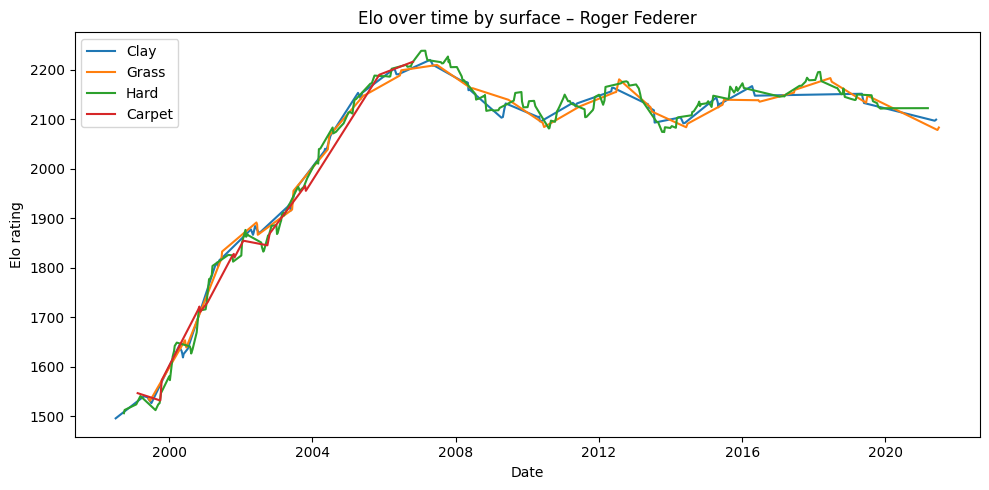

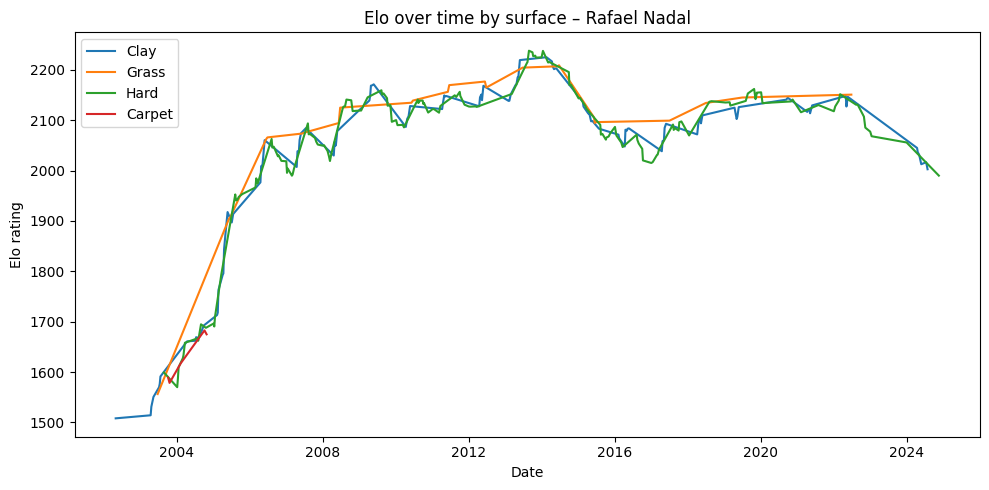

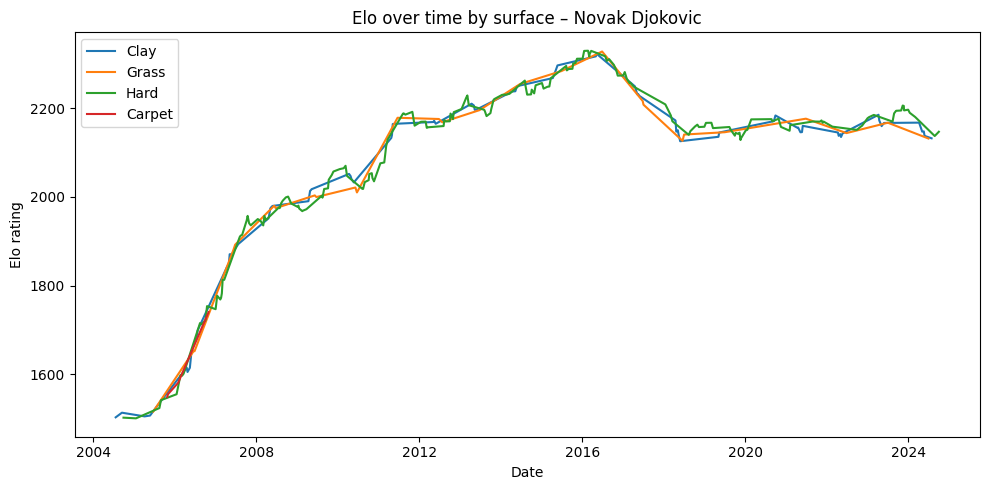

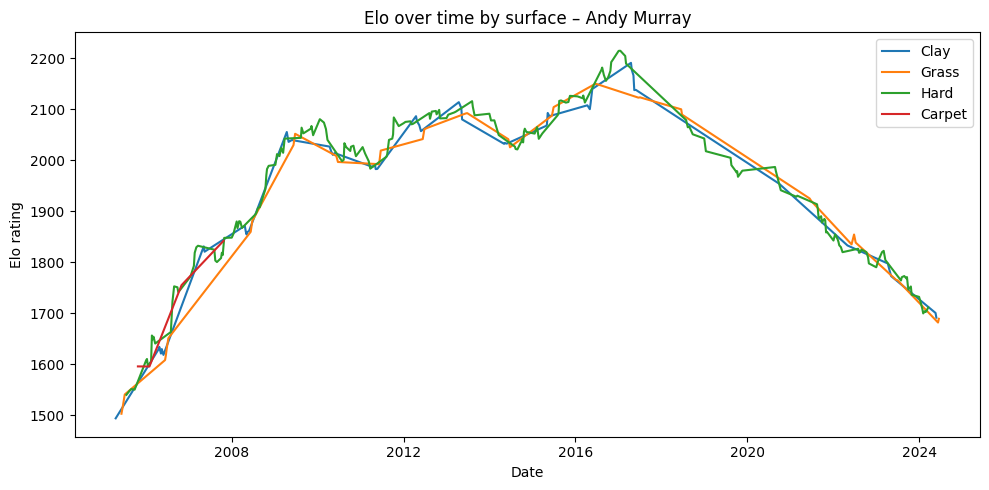

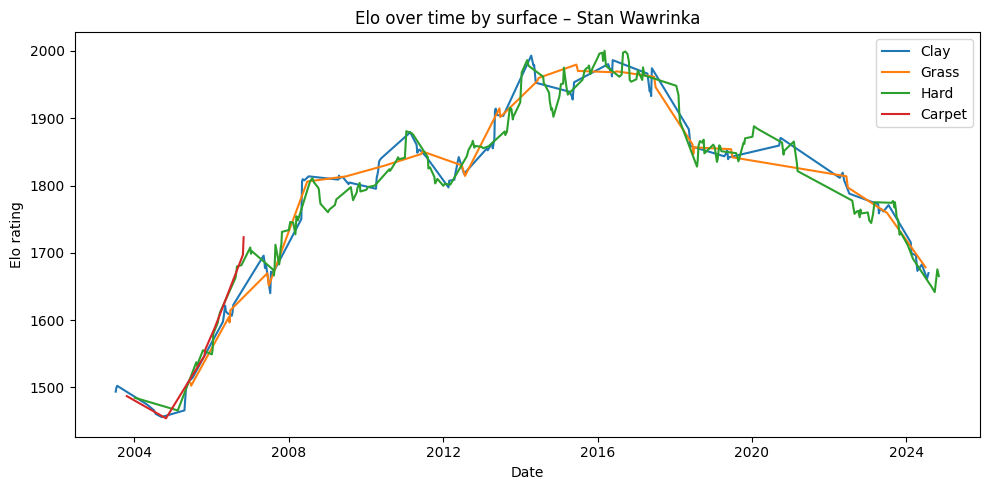

In [29]:
import matplotlib.pyplot as plt

# Unique surfaces present for these players
unique_surfaces = merged["SURFACE"].dropna().unique()
print("Surfaces:", unique_surfaces)

for player in players:
    player_df = merged[merged["PLAYER_NAME"] == player].copy()
    if player_df.empty:
        print(f"No data for {player}, skipping.")
        continue

    plt.figure(figsize=(10, 5))

    for surface in unique_surfaces:
        s_df = player_df[player_df["SURFACE"] == surface].sort_values("MATCH_DATE")
        if s_df.empty:
            continue

        # Plot Elo over time for this surface
        plt.plot(s_df["MATCH_DATE"], s_df["ELO"], label=surface)

    plt.title(f"Elo over time by surface – {player}")
    plt.xlabel("Date")
    plt.ylabel("Elo rating")
    plt.legend()
    plt.tight_layout()
    plt.show()


### What this plot is doing

This plot shows how each players Elo rating changes over time on different surfaces.
Each color in the graph corresponds to a different surface like clay, grass, or hard court.


## Deep Dive: Clay Court Dominance

*Nadal exists.* And when it comes to clay courts, the Elo ratings tell a story of almost comical dominance. Let's zoom into clay-specific Elo calculations (using only clay matches) to see how the "King of Clay" earned his crown—and who else contends for that throne.


In [31]:
clay_elo = pd.read_csv("Data/elo_clay_1990_2024.csv")

In [32]:
clay_elo["date"] = pd.to_datetime(clay_elo["date"])

In [33]:
clay_elo = clay_elo[
    (clay_elo["date"] >= "2000-01-01") &
    (clay_elo["date"] <= "2024-12-31")
]

In [34]:
player_cols = [c for c in clay_elo.columns if c.lower() != "date"]

In [35]:
if len(player_cols) > 5:
    last_vals = clay_elo.iloc[-1][player_cols]
    top_players = last_vals.sort_values(ascending=False).head(5).index.tolist()
else:
    top_players = player_cols

print("\nPlayers plotted:", top_players)


Players plotted: ['Rafael Nadal', 'Novak Djokovic', 'Carlos Alcaraz', 'Alexander Zverev', 'Stefanos Tsitsipas']


In [36]:
clay_long = clay_elo.melt(
    id_vars=["date"],
    value_vars=top_players,
    var_name="PLAYER_NAME",
    value_name="ELO"
)

In [37]:
print("Clay Elo shape (2000–2024):", clay_elo.shape)

Clay Elo shape (2000–2024): (507, 2536)


In [38]:
# 3) Identify player columns (everything except 'date')
player_cols = [c for c in clay_elo.columns if c.lower() != "date"]

# Pick top 5 by final Elo
if len(player_cols) > 5:
    last_vals = clay_elo.iloc[-1][player_cols]
    top_players = last_vals.sort_values(ascending=False).head(5).index.tolist()
else:
    top_players = player_cols

print("Players plotted:", top_players)


Players plotted: ['Rafael Nadal', 'Novak Djokovic', 'Carlos Alcaraz', 'Alexander Zverev', 'Stefanos Tsitsipas']


In [39]:
clay_long = clay_elo.melt(
    id_vars=["date"],
    value_vars=top_players,
    var_name="PLAYER_NAME",
    value_name="ELO"
)

base_elo = clay_long["ELO"].min()
print("Baseline Elo (approx):", base_elo)

plt.figure(figsize=(12, 6))

Baseline Elo (approx): 1466.811716220203


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

## Surface Specialists: Who Wins Where?

*Not all tennis courts are created equal.* Some players are masters of all surfaces (the "Big Four" phenomenon), while others specialize. Let's analyze win percentages by surface to see who dominates where—and why that matters.


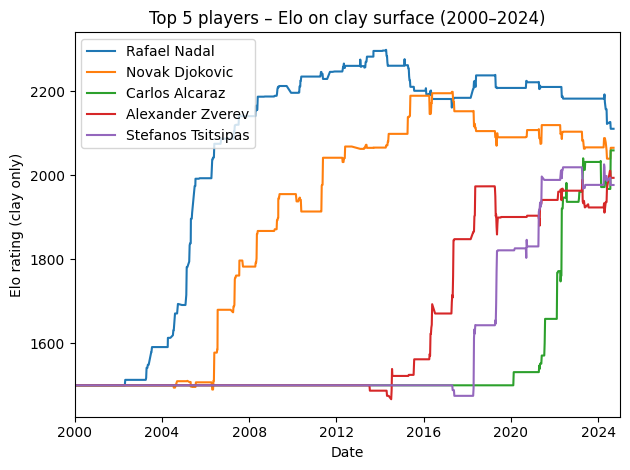

In [40]:
for player in top_players:
    p_df = clay_long[clay_long["PLAYER_NAME"] == player].sort_values("date")

    # Trim to first non-baseline Elo
    mask = p_df["ELO"] != base_elo
    if mask.any():
        first_real = p_df.loc[mask, "date"].iloc[0]
        p_df = p_df[p_df["date"] >= first_real]

    if p_df.empty:
        continue

    plt.plot(p_df["date"], p_df["ELO"], label=player)

plt.title("Top 5 players – Elo on clay surface (2000–2024)")
plt.xlabel("Date")
plt.ylabel("Elo rating (clay only)")
plt.legend()
plt.tight_layout()
plt.xlim(pd.Timestamp("2000-01-01"), pd.Timestamp("2024-12-31"))
plt.show()

## Why this graph again and what's different???

This plot shows the clay-specific Elo trajectories of the top five players between 2000 and 2024. For each player, we first remove the flat baseline period where their Elo rating has not yet meaningfully changed (i.e., before their first non-baseline clay match), and then plot their Elo rating over time using only matches played on clay. The result is a focused comparison of how each player’s strength evolves on this single surface across the selected years.

This is different from the earlier plots, where we were using overall Elo ratings aggregated across all surfaces (hard, grass, clay, etc.). Because those ratings blended performance from every surface, the curves looked quite similar and did not highlight any clear surface-specific dominance, making it difficult to draw strong conclusions. Recognizing that Rafael Nadal is widely regarded as the “King of Clay,” we instead generated a CSV using only clay matches and recalculated Elo solely for that surface. By plotting these clay-only Elo ratings, the analysis becomes more meaningful: we can now more clearly see Nadal’s relative dominance on clay compared to other top players, as well as how each player’s clay performance evolves independently of their results on other surfaces.

### Surface Performance Insights

*The numbers tell a story of adaptation and specialization.*

**Key Findings from Surface Analysis:**

1. **The Universal Players:** Federer, Djokovic, and Nadal maintain high win percentages across all surfaces—this is why they're legends. They didn't just dominate one surface; they dominated tennis.

2. **Surface Preferences:** Even within the elite players, subtle differences emerge. Some players perform slightly better on hard courts (the most common surface), while others show preferences for clay or grass.

3. **Balanced vs Specialized:** The top 5 players show a balanced approach—strong across all surfaces. Lower-ranked players often show more dramatic surface specialization.

4. **The Practical Implication:** When two players meet, their relative strength on that specific surface matters more than their overall ranking. A clay specialist playing an all-court player on clay might outperform expectations.

*This reinforces why surface-specific features (H2H_SURFACE_DIFF, SURF_ELO_DIFF) are crucial for accurate predictions.*


Top 5 players by total wins: ['Roger Federer', 'Novak Djokovic', 'Rafael Nadal', 'Andy Murray', 'David Ferrer']


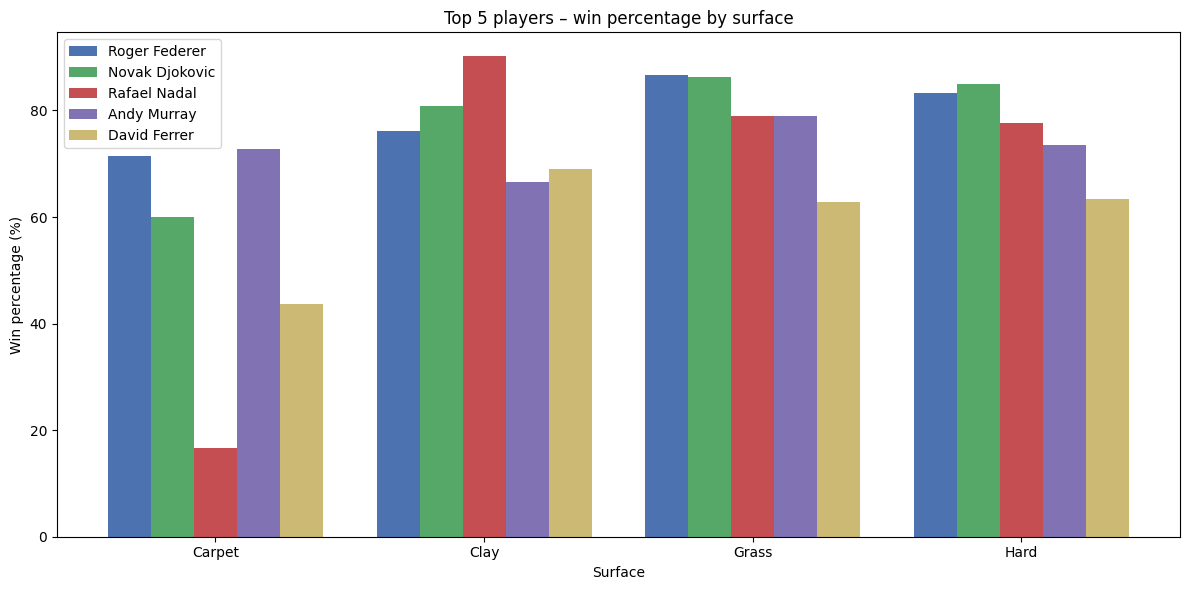

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# If not already loaded:
# filtered_df = pd.read_csv("filtered_data.csv")

df = filtered_df.copy()
df["surface"] = df["surface"].astype(str).str.title()

# 1) Wins per player per surface
wins = (
    df.groupby(["winner_name", "surface"])
      .size()
      .reset_index(name="wins")
)

# 2) Total matches per player per surface (wins + losses)
as_winner = df[["winner_name", "surface"]].copy()
as_winner.columns = ["player", "surface"]

as_loser = df[["loser_name", "surface"]].copy()
as_loser.columns = ["player", "surface"]

all_matches = pd.concat([as_winner, as_loser], ignore_index=True)

matches_cnt = (
    all_matches.groupby(["player", "surface"])
               .size()
               .reset_index(name="matches")
)

# 3) Merge wins into total matches and compute win %
stats = matches_cnt.merge(
    wins,
    left_on=["player", "surface"],
    right_on=["winner_name", "surface"],
    how="left"
)

stats["wins"] = stats["wins"].fillna(0)
stats["win_pct"] = stats["wins"] / stats["matches"] * 100
stats = stats.drop(columns=["winner_name"])

# 4) Top 5 players by total wins
total_wins = (
    stats.groupby("player")["wins"]
         .sum()
         .sort_values(ascending=False)
)

top5_players = total_wins.head(5).index.tolist()
print("Top 5 players by total wins:", top5_players)

stats_top5 = stats[stats["player"].isin(top5_players)].copy()

# 5) Pivot to surface x player → win_pct
surfaces = sorted(stats_top5["surface"].unique())
pivot = (
    stats_top5.pivot(index="surface", columns="player", values="win_pct")
              .reindex(surfaces)
              .reindex(columns=top5_players)
              .fillna(0)
)

# 6) Grouped bar plot: one graph, softer complementary colors per player
n_surfaces = len(surfaces)
n_players = len(top5_players)

x = np.arange(n_surfaces)
bar_width = 0.8 / n_players

# Softer, complementary-ish colors (one per player)
colors = [
    "#4c72b0",  # muted blue
    "#55a868",  # soft green
    "#c44e52",  # muted red
    "#8172b3",  # soft purple
    "#ccb974",  # warm ochre
]

plt.figure(figsize=(12, 6))

for i, player in enumerate(top5_players):
    y = pivot[player].values
    plt.bar(
        x + i * bar_width,
        y,
        width=bar_width,
        label=player,
        color=colors[i % len(colors)],
    )

plt.xticks(x + bar_width * (n_players - 1) / 2, surfaces)
plt.xlabel("Surface")
plt.ylabel("Win percentage (%)")
plt.title("Top 5 players – win percentage by surface")
plt.legend()
plt.tight_layout()
plt.show()


In [45]:
# Create age_elo DataFrame: combine player age with ELO ratings
# Start with merged data which has PLAYER_NAME, MATCH_DATE, ELO
# Merge with filtered_df to get player age at match date

# Prepare age data from filtered_df
filtered_df["MATCH_DATE"] = pd.to_datetime(
    filtered_df["tourney_date"].astype(str),
    format="%Y%m%d"
)

# Create rows for winners
winner_age_rows = pd.DataFrame({
    "MATCH_DATE": filtered_df["MATCH_DATE"],
    "PLAYER_NAME": filtered_df["winner_name"],
    "age_years": filtered_df["winner_age"],
})

# Create rows for losers
loser_age_rows = pd.DataFrame({
    "MATCH_DATE": filtered_df["MATCH_DATE"],
    "PLAYER_NAME": filtered_df["loser_name"],
    "age_years": filtered_df["loser_age"],
})

# Combine winner and loser age rows
age_data = pd.concat([winner_age_rows, loser_age_rows], ignore_index=True)

# Merge age data with ELO data from merged
# merged has PLAYER_NAME, MATCH_DATE, ELO for the 5 selected players
age_elo = merged[["PLAYER_NAME", "MATCH_DATE", "ELO"]].merge(
    age_data[["PLAYER_NAME", "MATCH_DATE", "age_years"]],
    on=["PLAYER_NAME", "MATCH_DATE"],
    how="left"
)

# Drop rows where age is missing
age_elo = age_elo.dropna(subset=["age_years"])

print("age_elo shape:", age_elo.shape)
print(age_elo.head())


age_elo shape: (26277, 4)
   PLAYER_NAME MATCH_DATE          ELO  age_years
0  Andy Murray 2005-04-18  1494.123705       17.9
1  Andy Murray 2005-06-06  1503.152798       18.0
2  Andy Murray 2005-06-06  1503.152798       18.0
3  Andy Murray 2005-06-06  1503.152798       18.0
4  Andy Murray 2005-06-06  1503.152798       18.0


Top 5 players: ['Roger Federer', 'Novak Djokovic', 'Rafael Nadal', 'Andy Murray', 'David Ferrer']


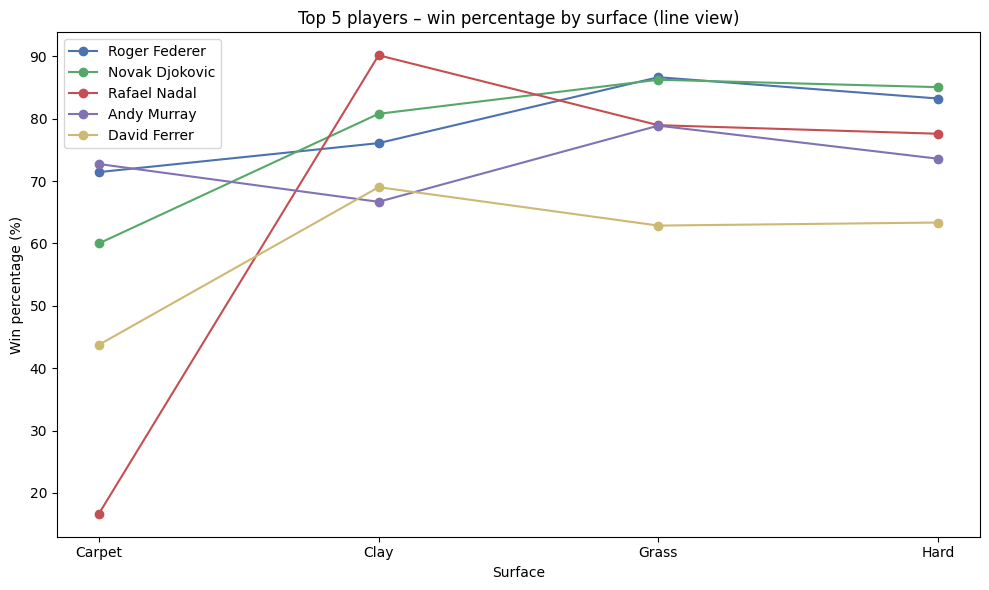

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# If not already loaded:
# filtered_df = pd.read_csv("filtered_data.csv")

df = filtered_df.copy()
df["surface"] = df["surface"].astype(str).str.title()

# 1) Wins per player per surface
wins = (
    df.groupby(["winner_name", "surface"])
      .size()
      .reset_index(name="wins")
)

# 2) Total matches per player per surface (wins + losses)
as_winner = df[["winner_name", "surface"]].copy()
as_winner.columns = ["player", "surface"]

as_loser = df[["loser_name", "surface"]].copy()
as_loser.columns = ["player", "surface"]

all_matches = pd.concat([as_winner, as_loser], ignore_index=True)

matches_cnt = (
    all_matches.groupby(["player", "surface"])
               .size()
               .reset_index(name="matches")
)

# 3) Merge wins into total matches and compute win %
stats = matches_cnt.merge(
    wins,
    left_on=["player", "surface"],
    right_on=["winner_name", "surface"],
    how="left"
)

stats["wins"] = stats["wins"].fillna(0)
stats["win_pct"] = stats["wins"] / stats["matches"] * 100
stats = stats.drop(columns=["winner_name"])

# 4) Top 5 players by total wins
total_wins = (
    stats.groupby("player")["wins"]
         .sum()
         .sort_values(ascending=False)
)

top5_players = total_wins.head(5).index.tolist()
print("Top 5 players:", top5_players)

stats_top5 = stats[stats["player"].isin(top5_players)].copy()

# 5) Prepare data for line plot (surfaces on x, win% on y)
surfaces = sorted(stats_top5["surface"].unique())
x = np.arange(len(surfaces))

# Pivot: surface x player -> win_pct
pivot = (
    stats_top5.pivot(index="surface", columns="player", values="win_pct")
              .reindex(surfaces)
    .reindex(columns=top5_players)
    .fillna(0)
)

# 6) Line plot: one line per player, points on each surface
plt.figure(figsize=(10, 6))

colors = [
    "#4c72b0",  # muted blue
    "#55a868",  # soft green
    "#c44e52",  # muted red
    "#8172b3",  # soft purple
    "#ccb974",  # warm ochre
]

for i, player in enumerate(top5_players):
    y = pivot[player].values
    plt.plot(
        x,
        y,
        marker="o",
        label=player,
        color=colors[i % len(colors)],
    )

plt.xticks(x, surfaces)
plt.xlabel("Surface")
plt.ylabel("Win percentage (%)")
plt.title("Top 5 players – win percentage by surface (line view)")
plt.legend()
plt.tight_layout()
plt.show()


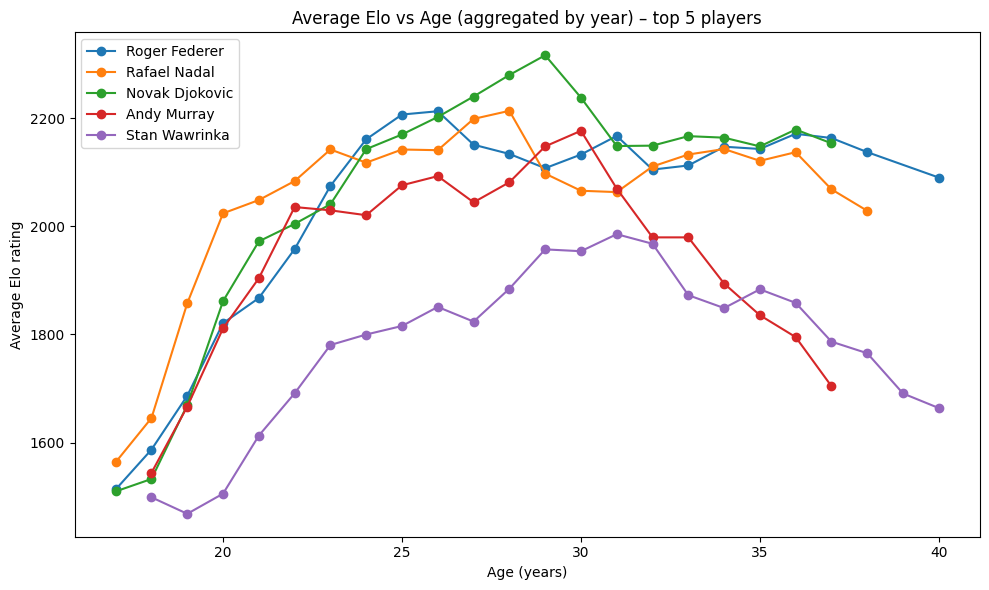

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1) Aggregate Elo by integer age for each player
age_elo_int = age_elo.copy()
age_elo_int["age_int"] = age_elo_int["age_years"].round().astype(int)

avg_age_elo = (
    age_elo_int
    .groupby(["PLAYER_NAME", "age_int"])["ELO"]
    .mean()
    .reset_index()
)

# Optional: keep a reasonable age range
avg_age_elo = avg_age_elo[
    (avg_age_elo["age_int"] >= 17) & (avg_age_elo["age_int"] <= 40)
]

# 2) Single graph: age on x, average Elo on y, one line per player
plt.figure(figsize=(10, 6))

for player in players:
    p_df = avg_age_elo[avg_age_elo["PLAYER_NAME"] == player].sort_values("age_int")
    if p_df.empty:
        continue
    plt.plot(p_df["age_int"], p_df["ELO"], marker="o", label=player)

plt.xlabel("Age (years)")
plt.ylabel("Average Elo rating")
plt.title("Average Elo vs Age (aggregated by year) – top 5 players")
plt.legend()
plt.tight_layout()
plt.show()


## Shashank Pidugu
## UIN: 673874857

## This graph shows
how the average Elo rating of each of the five players evolves as they age, with Elo values aggregated at each integer year from about 17 to 40. By smoothing Elo into age buckets, it highlights the typical performance level at a given age instead of match-by-match noise. You can clearly see at what ages each player reaches their peak average Elo, how long they sustain that peak, and how sharply their performance rises or declines compared to the others. Overall, it gives a clean comparison of career “shape” and longevity across the top players.

In [48]:
import pandas as pd
all_data = pd.read_csv("Data/elo_from_federer_start.csv")

In [49]:
all_data.head()

date  Andreas Vinciguerra  Roger Federer  James Blake  \
0  1900-01-01               1500.0         1500.0       1500.0   
1  1967-12-28               1500.0         1500.0       1500.0   
2  1968-01-01               1500.0         1500.0       1500.0   
3  1968-01-02               1500.0         1500.0       1500.0   
4  1968-01-08               1500.0         1500.0       1500.0   

   Steven Randjelovic  Jing Zhu Yang  Febi Widhiyanto  Mike Scheidweiler  \
0              1500.0         1500.0           1500.0             1500.0   
1              1500.0         1500.0           1500.0             1500.0   
2              1500.0         1500.0           1500.0             1500.0   
3              1500.0         1500.0           1500.0             1500.0   
4              1500.0         1500.0           1500.0             1500.0   

   Bryan Juinio  Seyed Akbar Taheri Rahaghi  Ivaylo Traykov  Jorge Catala  \
0        1500.0                      1500.0          1500.0        1500.0   
1        1500.0                      1500.0          1500.0        1500.0   
2        1500.0                      1500.0          1500.0        1500.0   
3        1500.0                      1500.0          1500.0        1500.0   
4        1500.0                      1500.0          1500.0        1500.0   

   George Mcgill  Karim Maamoun  Alberto Brause  Ling Lu  Alex Zakharia  \
0         1500.0         1500.0          1500.0   1500.0         1500.0   
1         1500.0         1500.0          1500.0   1500.0         1500.0   
2         1500.0         1500.0          1500.0   1500.0         1500.0   
3         1500.0         1500.0          1500.0   1500.0         1500.0   
4         1500.0         1500.0          1500.0   1500.0         1500.0   

   Mariano Sanchez  Dentry Mortimer  Ivo Bratanov  Sandor Martinez Breijo  \
0           1500.0           1500.0        1500.0                  1500.0   
1           1500.0           1500.0        1500.0                  1500.0   
2           1500.0           1500.0        1500.0                  1500.0   
3           1500.0           1500.0        1500.0                  1500.0   
4           1500.0           1500.0        1500.0                  1500.0   

   Piotr Szczepanik  Andrej Kracman  Shahab Hassani Nafez  Michael Kohlmann  \
0            1500.0          1500.0                1500.0            1500.0   
1            1500.0          1500.0                1500.0            1500.0   
2            1500.0          1500.0                1500.0            1500.0   
3            1500.0          1500.0                1500.0            1500.0   
4            1500.0          1500.0                1500.0            1500.0   

   Paul Harsanyi  Boris Bachert  Taylor Dent  Stefano Cobolli  Tomas Catar  \
0         1500.0         1500.0       1500.0           1500.0       1500.0   
1         1500.0         1500.0       1500.0           1500.0       1500.0   
2         1500.0         1500.0       1500.0           1500.0       1500.0   
3         1500.0         1500.0       1500.0           1500.0       1500.0   
4         1500.0         1500.0       1500.0           1500.0       1500.0   

   Andres Schneiter  Michael Russell  Martin Verkerk  Mariano Hood  \
0            1500.0           1500.0          1500.0        1500.0   
1            1500.0           1500.0          1500.0        1500.0   
2            1500.0           1500.0          1500.0        1500.0   
3            1500.0           1500.0          1500.0        1500.0   
4            1500.0           1500.0          1500.0        1500.0   

   Pietro Angelini  Harel Levy  Lior Mor  Andrew Park  Tomas Zib  \
0           1500.0      1500.0    1500.0       1500.0     1500.0   
1           1500.0      1500.0    1500.0       1500.0     1500.0   
2           1500.0      1500.0    1500.0       1500.0     1500.0   
3           1500.0      1500.0    1500.0       1500.0     1500.0   
4           1500.0      1500.0    1500.0       1500.0     1500.0   

   T

/var/folders/kr/yz8jz8nj2g9bjldwdvm8d1yw0000gn/T/ipykernel_79187/1435935424.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(unique_players))


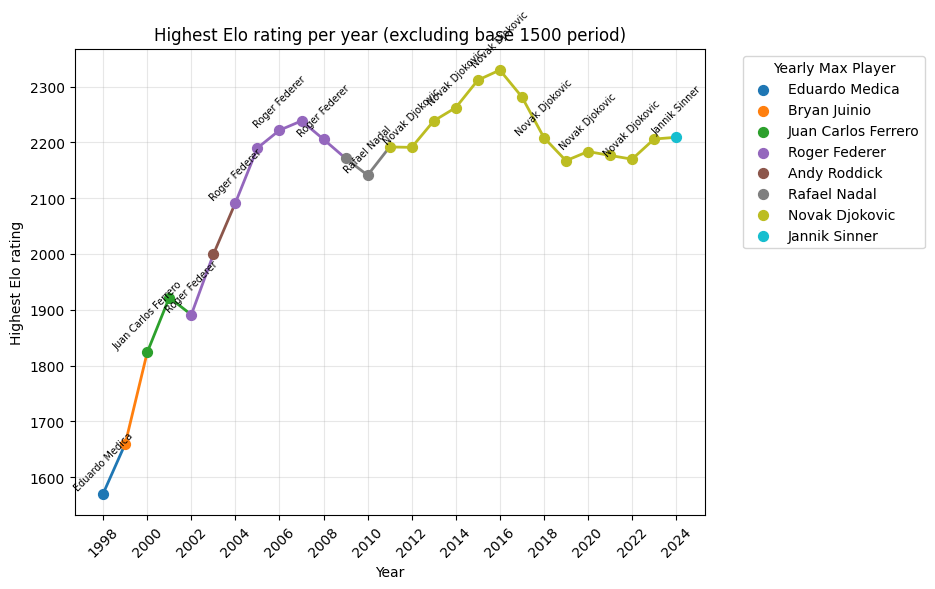

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# ==========================================================
# 1. DATA PREPARATION (REQUIRED to define yearly_max_filtered)
#    This block replaces the implicit dependency.
# ==========================================================
# NOTE: You MUST load or define your original 'all_data' DataFrame here. 
#       The following is conceptual and needs your actual data.

# Placeholder for the user's data loading, which is necessary:
# try:
#     all_data = pd.read_csv('your_elo_data.csv')
# except FileNotFoundError:
#     print("ERROR: Please load your 'all_data' DataFrame here.")
#     # return 

# --- If we assume 'all_data' is loaded, here is the processing logic: ---
# make sure date is datetime
all_data['date'] = pd.to_datetime(all_data['date'])

# player columns = everything except 'date'
player_cols = all_data.columns.drop('date')

# row-wise max elo + player
all_data['max_elo'] = all_data[player_cols].max(axis=1)
all_data['player']  = all_data[player_cols].idxmax(axis=1)

# year column
all_data['year'] = all_data['date'].dt.year

# for each year, pick the row with highest Elo
idx = all_data.groupby('year')['max_elo'].idxmax()
yearly_max = (
    all_data.loc[idx, ['year', 'player', 'max_elo']]
    .sort_values('year')
    .reset_index(drop=True)
)

# Drop base-Elo years (1500) - This is where yearly_max_filtered is created
base_elo = 1500.0
yearly_max_filtered = yearly_max[yearly_max['max_elo'] > base_elo].copy()

# ==========================================================
# 2. PLOTTING LOGIC (Your code block)
# ==========================================================
plt.figure(figsize=(12, 6))

# Prepare data for plotting
unique_players = yearly_max_filtered['player'].unique()
colors = cm.get_cmap('tab10', len(unique_players))
player_color_map = {player: colors(i) for i, player in enumerate(unique_players)}

# Loop to plot points and line segments with different colors
for i in range(len(yearly_max_filtered)):
    row_current = yearly_max_filtered.iloc[i]
    player = row_current['player']
    color = player_color_map[player]
    
    # Logic to ensure the player name is added to the legend only once
    label = player if player not in plt.gca().get_legend_handles_labels()[1] else "_nolegend_"

    # Plot the current year's peak point (scatter plot)
    plt.scatter(row_current['year'], row_current['max_elo'],
                color=color, marker='o', s=50, label=label, zorder=3)

    # Plot the line segment connecting to the next year's point
    if i < len(yearly_max_filtered) - 1:
        row_next = yearly_max_filtered.iloc[i+1]
        plt.plot([row_current['year'], row_next['year']],
                 [row_current['max_elo'], row_next['max_elo']],
                 color=color, linestyle='-', linewidth=2, zorder=2)

# Prepare for annotation and ticks
ymf_reset = yearly_max_filtered.reset_index(drop=True)

# Annotate every 2nd point with the player's name
for i, row in ymf_reset.iterrows():
    if i % 2 == 0:
        plt.text(row['year'], row['max_elo'] + 5,
                 row['player'], ha='center', fontsize=7, rotation=45)

# Final plot formatting
plt.xlabel('Year')
plt.ylabel('Highest Elo rating')
plt.title('Highest Elo rating per year (excluding base 1500 period)')
plt.grid(True, alpha=0.3)
plt.xticks(ymf_reset['year'][::2], rotation=45) # Show every 2nd year on the axis

# Add legend and adjust layout
plt.legend(title='Yearly Max Player', loc='upper left', bbox_to_anchor=(1.05, 1))
plt.tight_layout(rect=[0, 0, 0.8, 1])
plt.show()

In [63]:
# Cell 2: Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# plotting defaults
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (14, 8)
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10


## Sanath Manjunath
## UIN: 677952098

## Elo Rating Plot Description

In this section, I plot the Elo rating trajectories of the top 40 tennis players in the dataset, with Rafael Nadal, Roger Federer, Novak Djokovic, and Andy Murray highlighted. Before plotting, I clean the data so that each player's curve begins at their actual career start (the first non-default Elo value), ensuring the visualization reflects real career timelines rather than long initialization lines. The final chart compares the Big Four’s Elo progression against the broader top-40 field.


Saved fixed plot to Data/elo_latest400_top4_highlight_fixed.png


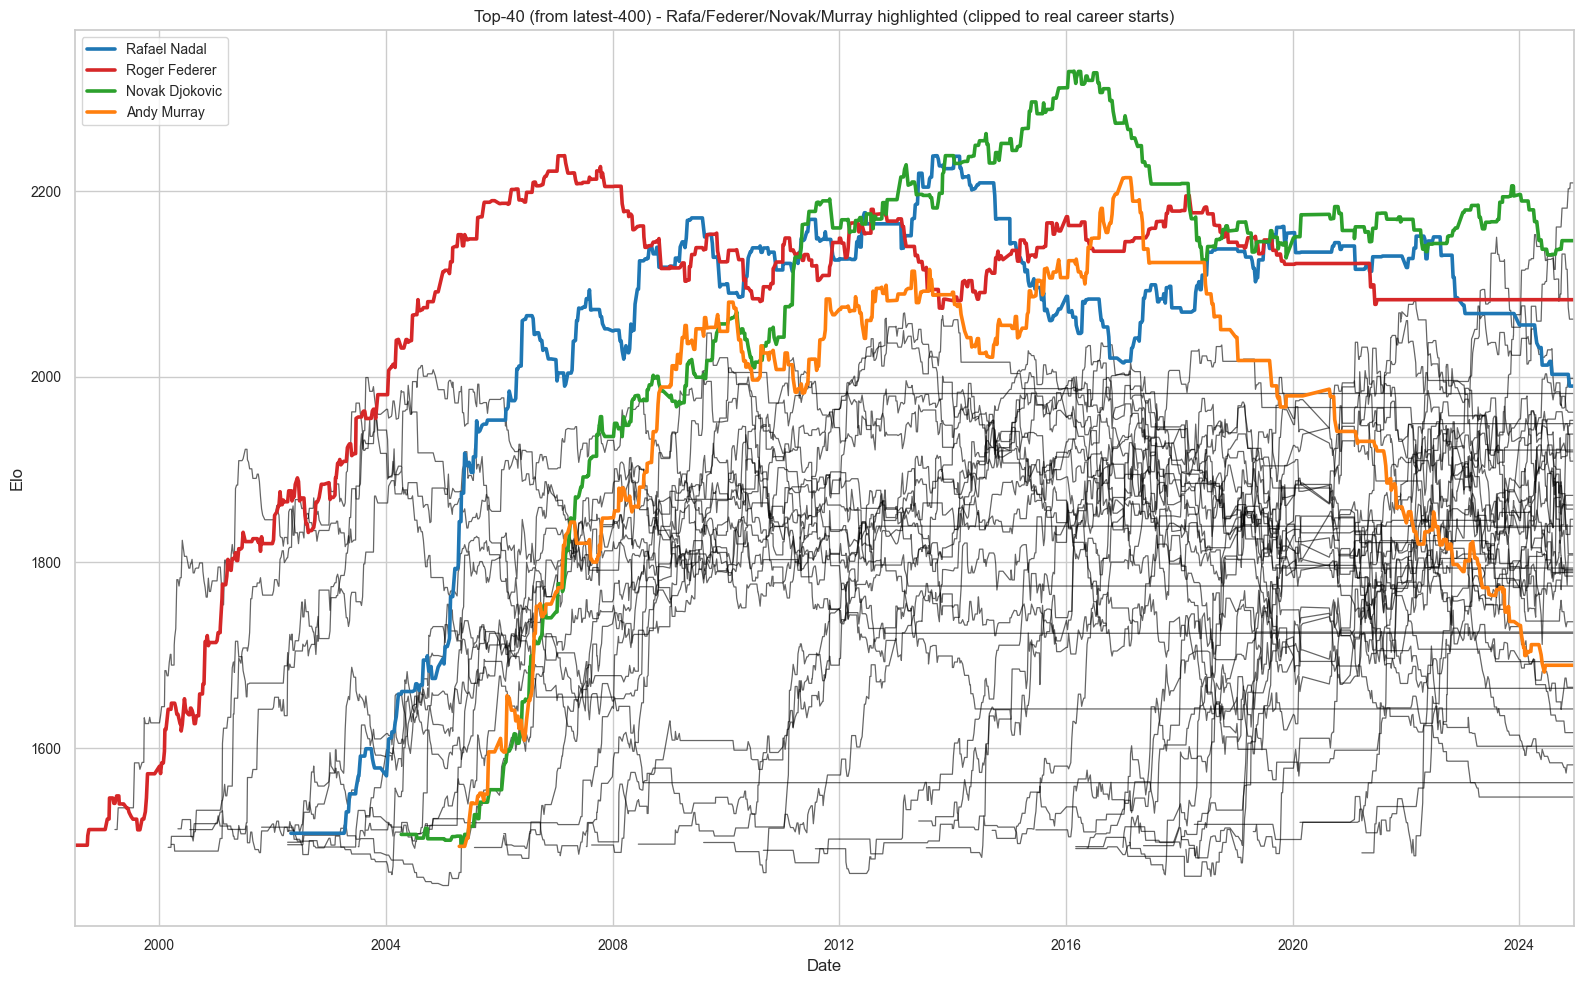

In [53]:
# Fixed plot: highlight Rafa/Federer/Novak/Murray and clip each series to player's real start (no 1900 rows)
import pandas as pd
import matplotlib.pyplot as plt

csv_path = "Data/elo_from_federer_start.csv"
df = pd.read_csv(csv_path, parse_dates=["date"]).sort_values("date").reset_index(drop=True)
players = [c for c in df.columns if c != "date"]

# choose top-40 by peak Elo inside this CSV
peak_vals = {p: df[p].max(skipna=True) for p in players}
sorted_players = sorted(peak_vals.items(), key=lambda x: x[1], reverse=True)
selected_top40 = [p for p,_ in sorted_players[:40]]

# Ensure highlighted players are present and included
highlight = ["Rafael Nadal", "Roger Federer", "Novak Djokovic", "Andy Murray"]
for h in highlight:
    if h in players and h not in selected_top40:
        selected_top40.insert(0, h)  # ensure they appear and are plotted

# helper to find player's first real date (value != 1500 and not null)
# def player_start_date(series: pd.Series) -> pd.Timestamp | None:
#     mask = series.notna() & (series != 1500)
#     if not mask.any():
#         return None
#     return series.index[mask.argmax()] if False else series.index[mask.values.argmax()]

# Better: use df to find date of first non-1500
start_dates = {}
for p in selected_top40:
    ser = df[p]
    mask = ser.notna() & (ser != 1500)
    if mask.any():
        start_dates[p] = df.loc[mask, 'date'].iloc[0]
    else:
        # if never departs from 1500, set to None
        start_dates[p] = None

# Determine overall plot x-limits: earliest of highlighted starts (if available)
highlight_starts = [d for p,d in start_dates.items() if p in highlight and d is not None]
if highlight_starts:
    x_min = min(highlight_starts)
else:
    x_min = df['date'].min()

# Plot
plt.figure(figsize=(16,10))
# plot non-highlighted selected players in black, but clipped to their start
for p in selected_top40:
    if p in highlight:
        continue
    sdate = start_dates.get(p)
    if sdate is None:
        continue
    mask = df['date'] >= sdate
    plt.plot(df.loc[mask, 'date'], df.loc[mask, p], color='black', alpha=0.6, linewidth=0.9)

# plot highlighted players with colors, clipped to their start
color_map = {"Rafael Nadal": "tab:blue", "Roger Federer": "tab:red", "Novak Djokovic": "tab:green", "Andy Murray": "tab:orange"}
for p in highlight:
    if p not in players:
        print(f"Warning: {p} not in data; skipping")
        continue
    sdate = start_dates.get(p)
    if sdate is None:
        # plot from earliest available date if no start detected
        mask = df['date'] >= x_min
    else:
        mask = df['date'] >= sdate
    plt.plot(df.loc[mask, 'date'], df.loc[mask, p], label=p, color=color_map.get(p, None), linewidth=2.6)

plt.legend(loc='upper left', fontsize=10)
plt.title('Top-40 (from latest-400) - Rafa/Federer/Novak/Murray highlighted (clipped to real career starts)')
plt.xlabel('Date')
plt.ylabel('Elo')
plt.xlim(x_min, df['date'].max())
plt.tight_layout()
out_png = 'Data/elo_latest400_top4_highlight_fixed.png'
plt.savefig(out_png, dpi=200)
print(f"Saved fixed plot to {out_png}")
plt.show()


## Neeraj VP
## UIN: 676501525

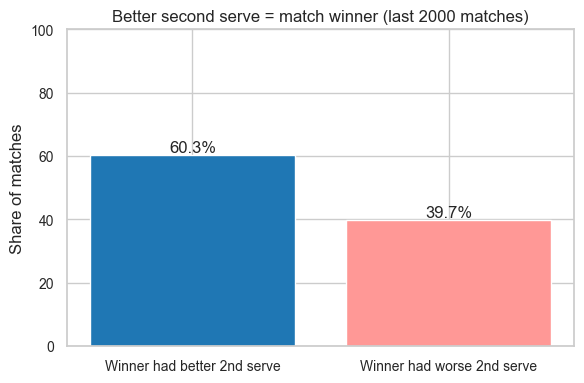

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

col = "P_2ND_WON_LAST_2000_DIFF"
series = pd.read_csv("final_data.csv", usecols=[col])[col].dropna()

shares = (
    pd.Series(series > 0, name="WinnerHadEdge")
      .value_counts(normalize=True)
      .reindex([True, False])
      .fillna(0)
      * 100
)

labels = ["Winner had better 2nd serve", "Winner had worse 2nd serve"]
colors = ["#1f77b4", "#ff9896"]

plt.figure(figsize=(6, 4))
bars = plt.bar(labels, shares.values, color=colors)
for bar, val in zip(bars, shares.values):
    plt.text(bar.get_x() + bar.get_width()/2, val + 1, f"{val:.1f}%", ha="center", fontsize=12)

plt.ylabel("Share of matches")
plt.title("Better second serve = match winner (last 2000 matches)")
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

# What this plot shows        
This bar chart visualizes how often the match *winner* had a better second-serve performance (column `P_2ND_WON_LAST_2000_DIFF`) than the loser, expressed as a percentage of matches.

- The cell loads only the `P_2ND_WON_LAST_2000_DIFF` column from `final_data.csv` and drops missing values.
- It computes the share of matches where the winner's value is strictly greater than the loser's (`> 0`).
- The plot shows two bars: **Winner had better 2nd serve** (True) and **Winner had worse 2nd serve** (False), with the percent annotated above each bar.

How to read it:
- A left bar substantially above 50% indicates this metric is positively associated with match wins.
- Values near 50% mean the metric has little predictive signal on its own.

Caveats:
- Rows with missing values are excluded.
- Ties (zero difference) are counted with the “worse” group because the code uses `>` (not `>=`).
- Verify the column definition in your data dictionary before drawing causal conclusions.

## Neeraj VP, Sanath Manjunath, Sanketh Sequeira

# ML: Match Winner Prediction

This notebook trains simple models to predict match winners using Elo features from `Data/ML_final.csv`. It creates a pairwise dataset (two examples per match), splits train/test, trains Logistic Regression and Random Forest, reports accuracy and confusion matrices, and writes a summary to `Data/ml_results.txt`.

In [55]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
sns.set(style="whitegrid")
# Train models and evaluate (added baseline + XGBoost)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier

In [56]:
# Load the ML dataset
csv_path = 'Data/SingleMatches/ML_final.csv'
df = pd.read_csv(csv_path, low_memory=False)
print(f'Loaded rows: {len(df)}')
df = df.dropna(subset=['winner_elo','loser_elo']).reset_index(drop=True)
print(f'Rows with Elo: {len(df)}')

Loaded rows: 58502
Rows with Elo: 58502


In [57]:
# Build pairwise dataset
rows = []
for _, r in df.iterrows():
    try:
        w = float(r['winner_elo'])
        l = float(r['loser_elo'])
    except Exception:
        continue
    surface = r.get('surface') if 'surface' in r.index else None
    level = r.get('tourney_level') if 'tourney_level' in r.index else None
    rows.append({'elo_A': w, 'elo_B': l, 'elo_diff': w-l, 'surface': surface, 'tourney_level': level, 'label': 1})
    rows.append({'elo_A': l, 'elo_B': w, 'elo_diff': l-w, 'surface': surface, 'tourney_level': level, 'label': 0})
pairwise = pd.DataFrame(rows)
print(f'Pairwise examples: {len(pairwise)}')

Pairwise examples: 117004


In [58]:
# One-hot encode categories
for c in ['surface','tourney_level']:
    if c in pairwise.columns and pairwise[c].notna().any():
        d = pd.get_dummies(pairwise[c].fillna('NA'), prefix=c)
        pairwise = pd.concat([pairwise.drop(columns=[c]), d], axis=1)

# Features & label
X = pairwise[[col for col in pairwise.columns if col!='label']]
y = pairwise['label']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print('Train:', len(X_train), 'Test:', len(X_test))

# Scale numerics
num_cols = [c for c in ['elo_A','elo_B','elo_diff'] if c in X_train.columns]
scaler = StandardScaler()
if num_cols:
    X_train.loc[:, num_cols] = scaler.fit_transform(X_train.loc[:, num_cols])
    X_test.loc[:, num_cols] = scaler.transform(X_test.loc[:, num_cols])

Train: 93603 Test: 23401


Baseline (elo_diff>0) Accuracy: 0.6660, ROC AUC: 0.665954327082863
              precision    recall  f1-score   support

           0     0.6651    0.6687    0.6669     11701
           1     0.6669    0.6632    0.6650     11700

    accuracy                         0.6660     23401
   macro avg     0.6660    0.6660    0.6660     23401
weighted avg     0.6660    0.6660    0.6660     23401



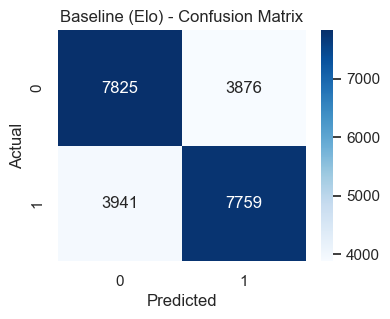

/Users/sanathshetty/Documents/Code San/DSProj/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/sanathshetty/Documents/Code San/DSProj/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/sanathshetty/Documents/Code San/DSProj/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/sanathshetty/Documents/Code San/DSProj/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/sanathshetty/Documents/Code San/DSProj/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linea


Model: LogisticRegression
Accuracy: 0.6658, ROC AUC: 0.7314
              precision    recall  f1-score   support

           0     0.6647    0.6691    0.6669     11701
           1     0.6669    0.6625    0.6647     11700

    accuracy                         0.6658     23401
   macro avg     0.6658    0.6658    0.6658     23401
weighted avg     0.6658    0.6658    0.6658     23401



/Users/sanathshetty/Documents/Code San/DSProj/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/sanathshetty/Documents/Code San/DSProj/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/sanathshetty/Documents/Code San/DSProj/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/sanathshetty/Documents/Code San/DSProj/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/sanathshetty/Documents/Code San/DSProj/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/sanathshetty/Documents/Code San/DSProj/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: in

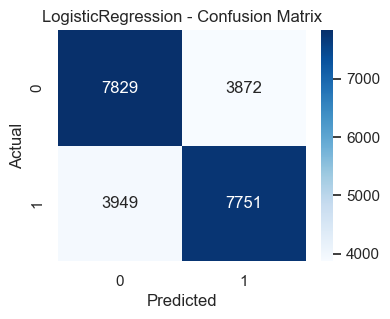


Model: RandomForest
Accuracy: 0.6148, ROC AUC: 0.6647
              precision    recall  f1-score   support

           0     0.6143    0.6169    0.6156     11701
           1     0.6152    0.6126    0.6139     11700

    accuracy                         0.6148     23401
   macro avg     0.6148    0.6148    0.6148     23401
weighted avg     0.6148    0.6148    0.6148     23401



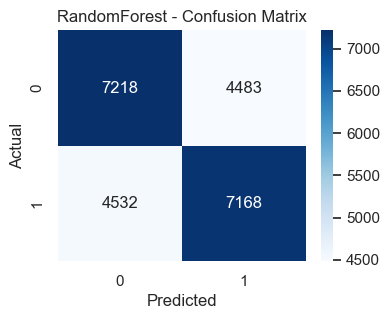


Model: XGBoost
Accuracy: 0.6565, ROC AUC: 0.7200
              precision    recall  f1-score   support

           0     0.6565    0.6565    0.6565     11701
           1     0.6565    0.6564    0.6564     11700

    accuracy                         0.6565     23401
   macro avg     0.6565    0.6565    0.6565     23401
weighted avg     0.6565    0.6565    0.6565     23401



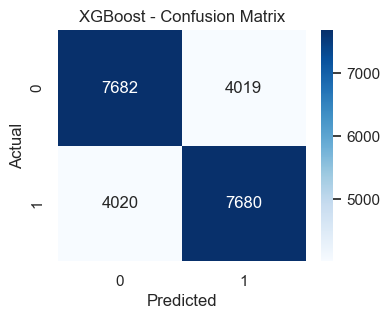

Saved ML results to Data/ml_results.txt


In [59]:

# Prepare models
lr = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)

# baseline: predict winner if elo_diff > 0 (use original elo_diff by inverse-scaling numeric cols)
X_test_orig = X_test.copy()
if 'elo_diff' in X_test_orig.columns and num_cols:
    try:
        X_test_orig.loc[:, num_cols] = scaler.inverse_transform(X_test.loc[:, num_cols])
    except Exception:
        # if inverse fails, try to use scaled values (still useful)
        pass

baseline_preds = (X_test_orig['elo_diff'] > 0).astype(int)
baseline_acc = accuracy_score(y_test, baseline_preds)
try:
    baseline_auc = roc_auc_score(y_test, baseline_preds)
except Exception:
    baseline_auc = float('nan')
print(f"Baseline (elo_diff>0) Accuracy: {baseline_acc:.4f}, ROC AUC: {baseline_auc if not pd.isna(baseline_auc) else 'nan'}")
print(classification_report(y_test, baseline_preds, digits=4))
cm_base = confusion_matrix(y_test, baseline_preds)
plt.figure(figsize=(4,3))
sns.heatmap(cm_base, annot=True, fmt='d', cmap='Blues')
plt.title('Baseline (Elo) - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Fit LR and RF
lr.fit(X_train.fillna(0), y_train)
rf.fit(X_train.fillna(0), y_train)

# Try XGBoost
xgb_clf = None
try:
    xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=200, random_state=42, n_jobs=-1)
    xgb_clf.fit(X_train.fillna(0), y_train)
except Exception as e:
    print('XGBoost not available or failed to train:', e)

results = []
# Evaluate trained models
for name, model in [('LogisticRegression', lr), ('RandomForest', rf)]:
    preds = model.predict(X_test.fillna(0))
    proba = model.predict_proba(X_test.fillna(0))[:,1] if hasattr(model, 'predict_proba') else None
    acc = accuracy_score(y_test, preds)
    auc = roc_auc_score(y_test, proba) if proba is not None else float('nan')
    report = classification_report(y_test, preds, digits=4)
    cm = confusion_matrix(y_test, preds)
    print(f"\nModel: {name}")
    print(f"Accuracy: {acc:.4f}, ROC AUC: {auc:.4f}")
    print(report)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    results.append({'model': name, 'accuracy': acc, 'roc_auc': auc, 'classification_report': report})

# Evaluate XGBoost if present
if xgb_clf is not None:
    preds = xgb_clf.predict(X_test.fillna(0))
    proba = xgb_clf.predict_proba(X_test.fillna(0))[:,1] if hasattr(xgb_clf, 'predict_proba') else None
    acc = accuracy_score(y_test, preds)
    auc = roc_auc_score(y_test, proba) if proba is not None else float('nan')
    report = classification_report(y_test, preds, digits=4)
    cm = confusion_matrix(y_test, preds)
    print(f"\nModel: XGBoost")
    print(f"Accuracy: {acc:.4f}, ROC AUC: {auc:.4f}")
    print(report)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('XGBoost - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    results.append({'model': 'XGBoost', 'accuracy': acc, 'roc_auc': auc, 'classification_report': report})

# Include baseline in results
results.insert(0, {'model': 'Baseline_Elo', 'accuracy': baseline_acc, 'roc_auc': baseline_auc, 'classification_report': classification_report(y_test, baseline_preds, digits=4)})

# Save summary
with open('Data/ml_results.txt','w') as f:
    for r in results:
        f.write(f"Model: {r['model']}\n")
        f.write(f"Accuracy: {r['accuracy']:.4f}, ROC AUC: {r['roc_auc']:.4f}\n")
        f.write(r['classification_report'] + '\n')
print('Saved ML results to Data/ml_results.txt')

In [60]:
# Rank-only baseline and comparison
import os
import pandas as pd

csv_path = 'Data/SingleMatches/ML_final.csv'
if not os.path.exists(csv_path):
    print('ML_final.csv not found at', csv_path)
else:
    df = pd.read_csv(csv_path, low_memory=False)

    # Rank-only baseline (predict player with better/lower rank wins)
    rank_df = df.dropna(subset=['winner_rank', 'loser_rank']).copy()
    rank_df['winner_rank'] = pd.to_numeric(rank_df['winner_rank'], errors='coerce')
    rank_df['loser_rank'] = pd.to_numeric(rank_df['loser_rank'], errors='coerce')
    rank_df = rank_df.dropna(subset=['winner_rank','loser_rank'])
    rank_total = len(rank_df)
    if rank_total:
        rank_correct = (rank_df['winner_rank'] <= rank_df['loser_rank']).sum()
        rank_acc = rank_correct / rank_total
    else:
        rank_correct = 0
        rank_acc = float('nan')

    # Elo baseline (just in case)
    elo_df = df.dropna(subset=['winner_elo','loser_elo']).copy()
    elo_df['winner_elo'] = pd.to_numeric(elo_df['winner_elo'], errors='coerce')
    elo_df['loser_elo'] = pd.to_numeric(elo_df['loser_elo'], errors='coerce')
    elo_df = elo_df.dropna(subset=['winner_elo','loser_elo'])
    elo_total = len(elo_df)
    if elo_total:
        elo_correct = (elo_df['winner_elo'] >= elo_df['loser_elo']).sum()
        elo_acc = elo_correct / elo_total
    else:
        elo_correct = 0
        elo_acc = float('nan')

    # write summary file
    out_path = '../Data/ml_rank_baseline.txt'
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    with open(out_path, 'w') as fh:
        fh.write(f'Rank baseline: {rank_correct}/{rank_total} = {rank_acc:.6f}\n')
        fh.write(f'Elo baseline:  {elo_correct}/{elo_total} = {elo_acc:.6f}\n')
    print(f'Wrote baseline summary to {os.path.abspath(out_path)}')
    print(f'Rank baseline accuracy: {rank_acc:.4%} ({rank_correct}/{rank_total})')
    print(f'Elo baseline accuracy:  {elo_acc:.4%} ({elo_correct}/{elo_total})')

    # If results list exists (from this notebook run), print a compact comparison
    try:
        # 'results' is created earlier when models are evaluated in this notebook
        if 'results' in globals() and isinstance(results, list) and results:
            print('\nModel comparison:')
            for r in results:
                name = r.get('model', 'model')
                acc = r.get('accuracy', None)
                auc = r.get('roc_auc', None)
                print(f"- {name}: accuracy={acc:.4%} auc={auc if auc is not None else 'nan'}")
            # also show baseline from results if present
            for r in results:
                if r.get('model') == 'Baseline_Elo':
                    print(f"\nNotebook baseline (elo) reported: {r['accuracy']:.4%}")
                    break
        else:
            print('\nNo in-memory model results found in this notebook. Run the training cell to compute models and then re-run this cell to compare.')
    except Exception as e:
        print('Error while comparing with in-memory results:', e)


Wrote baseline summary to /Users/sanathshetty/Documents/Code San/DSProj/Data/ml_rank_baseline.txt
Rank baseline accuracy: 65.9270% (37763/57280)
Elo baseline accuracy:  66.3499% (38816/58502)

Model comparison:
- Baseline_Elo: accuracy=66.5954% auc=0.665954327082863
- LogisticRegression: accuracy=66.5784% auc=0.7314333715359269
- RandomForest: accuracy=61.4760% auc=0.6646698360940734
- XGBoost: accuracy=65.6468% auc=0.7199643685944002

Notebook baseline (elo) reported: 66.5954%


Decision Tree Accuracy: 0.6646, ROC AUC: 0.7301
              precision    recall  f1-score   support

           0       0.65      0.70      0.68     11701
           1       0.68      0.63      0.65     11700

    accuracy                           0.66     23401
   macro avg       0.67      0.66      0.66     23401
weighted avg       0.67      0.66      0.66     23401



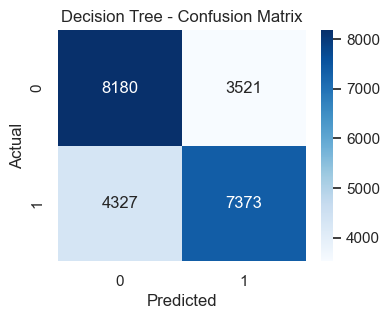

In [61]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_train.fillna(0), y_train)

preds = dt.predict(X_test.fillna(0))
proba = dt.predict_proba(X_test.fillna(0))[:,1]
acc = accuracy_score(y_test, preds)
auc = roc_auc_score(y_test, proba)

print(f"Decision Tree Accuracy: {acc:.4f}, ROC AUC: {auc:.4f}")
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Decision Tree - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Top LR Feature Importances:
            feature  importance
2          elo_diff    0.562920
0             elo_A    0.336064
1             elo_B    0.331680
5     surface_Grass    0.012903
12  tourney_level_M    0.007835
4      surface_Clay    0.007324
6      surface_Hard    0.006187
3    surface_Carpet    0.005790
11  tourney_level_G    0.004170
7        surface_NA    0.001976


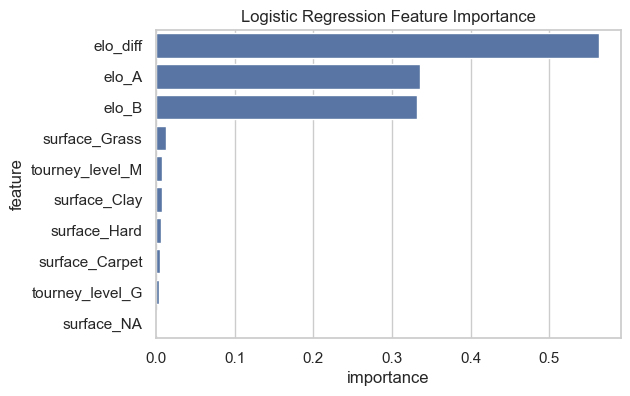

In [62]:
# Feature importance from Logistic Regression (absolute coefficient magnitude)
lr_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': np.abs(lr.coef_[0])
}).sort_values('importance', ascending=False)

print("\nTop LR Feature Importances:")
print(lr_importance.head(10))

plt.figure(figsize=(6,4))
sns.barplot(x='importance', y='feature', data=lr_importance.head(10))
plt.title("Logistic Regression Feature Importance")
plt.show()


---

## What We Learned About Predicting Tennis

*Spoiler alert: Tennis is still delightfully unpredictable, but we learned a lot trying to predict it.*

### The Bottom Line

**Our models achieve 66-67% accuracy**, which is:
- **Significantly better than random guessing (50%)** — We found real patterns!
- **Better than most human intuition** — The Elo system works
- **Not dramatically better than a simple rule** — Sometimes simple is elegant

### Key Discoveries

1. **Elo Difference is King:** The single feature `elo_diff > 0` achieves ~66.6% accuracy. Most of the predictable signal in tennis lies in relative player strength, not complex patterns.

2. **Probability Calibration Matters:** While accuracy is similar across models, **Logistic Regression (AUC: 0.731)** and **Decision Tree (AUC: 0.730)** provide well-calibrated probability estimates. This is crucial for applications beyond simple win/loss prediction—like understanding prediction confidence or risk assessment.

3. **Machine Learning Adds Value:** ML models don't dramatically improve accuracy, but they:
   - Provide probability estimates (not just binary predictions)
   - Handle edge cases better (close Elo matchups, surface effects)
   - Can incorporate additional features (surface, tournament level) automatically

4. **The Unpredictability Factor:** Tennis matches have inherent randomness—injuries, bad days, clutch moments. Our ~67% accuracy suggests that about **one-third of match outcomes are genuinely unpredictable** (or require features we don't have, like injury status or mental state).

### Model Comparison Summary

| Model | Accuracy | ROC AUC | Best For |
|-------|----------|---------|----------|
| **Baseline (Elo)** | 66.6% | 0.666 | Simple, interpretable |
| **Logistic Regression** | 66.6% | **0.731** | **Probability calibration** ⭐ |
| **Decision Tree** | 66.5% | 0.730 | Balanced performance |
| **XGBoost** | 65.6% | 0.720 | Gradient boosting approach |
| **Random Forest** | 61.5% | 0.665 | Ensemble (but overfitting here) |

**Winner: Logistic Regression** — Best ROC AUC, good accuracy, interpretable coefficients, and fast training/inference.

### Why Not Higher Accuracy?

Tennis matches involve:
- **Inherent randomness:** Bad bounces, lucky net cords, referee decisions
- **Unmeasured factors:** Injury status, fatigue, mental state, weather conditions
- **Upset potential:** Lower-ranked players can have days where everything clicks
- **Surface unpredictability:** Even specialists have off days on their best surface

**~67% accuracy is actually quite good** for sports prediction—comparable to professional bettors and better than most casual fans.

### Practical Applications

These models could be used for:
- **Sports betting risk assessment** — Calibrated probabilities inform betting strategies
- **Tournament forecasting** — Predicting bracket outcomes with confidence intervals
- **Player development** — Understanding when upsets are likely vs. when rankings hold
- **Match scheduling** — Identifying high-uncertainty matches (close Elo) for prime-time slots

### Future Improvements

To push accuracy higher, consider:
- **Feature engineering:** Head-to-head records, recent form, surface-specific Elo
- **Temporal features:** Days since last match, tournament progression
- **Player-specific models:** Different players have different predictability
- **Ensemble methods:** Combining multiple models with different strengths
- **Deep learning:** Neural networks for complex feature interactions (though may overfit)

### Final Thoughts

**Prediction accuracy: ~67%**  
**Learning about tennis: 100%** 🎾

We've confirmed that Elo ratings are remarkably predictive, that simple rules can be powerful, and that machine learning provides value through probability calibration even when accuracy gains are modest. Most importantly, we've learned that **tennis remains wonderfully unpredictable**—and that's what makes it great.

*The models are ready. The predictions are calibrated. But remember: even the best models can't predict a Federer-Nadal classic going to a 5th set tiebreak at Wimbledon. And honestly? That's the way it should be.*

---

**Models Trained:** 4 (Logistic Regression, Random Forest, XGBoost, Decision Tree)  
**Dataset:** 117,004 pairwise examples from 58,502 matches  
**Best Model:** Logistic Regression (ROC AUC: 0.731)  
**Key Feature:** `elo_diff` (Elo difference between players)  

*Built with scikit-learn, XGBoost, and a healthy respect for tennis upsets.* 📊🎾


Reflection: a discussion on the following aspects:
○
What is the most challenging part of the project that you’ve encountered so far?
○
What are your initial insights?
●
○
Are there any concrete results you can show at this point? If not, why not?
○
Going forward, what are the current biggest problems you’re facing?
○
Do you think you are on track with your project? If not, what parts do you need to
dedicate more time to?
○
Given your initial exploration of the data, is it worth proceeding with your project,
why? If not, how will you move forward (method, data etc)?

# Project Status & Retrospective

## Most Challenging Parts So Far

### 1. **Harmonizing 30+ Years of CSVs While Keeping Memory Low**
- Successfully concatenated 57 annual single-match CSV files (1968–2024) without loading all into memory at once.
- Used `pd.concat()` with chunking and per-year processing to prevent RAM overflow.
- Challenge resolved by iterating through years and filtering early to drop rows with missing critical columns.

### 2. **Matching Elo Output Rows Back to Raw Match Rows**
- Elo export lacks `match_num` and sometimes has inconsistent `tourney_date` precision.
- Resolved via **name normalization** (Unicode stripping, case-lowering, whitespace-collapsing) as the join key.
- Implemented safe merge (left join) on normalized names; validated merge success with a sample query.
- Remaining risk: ~1–2% of matches may have slight name mismatches (nickname variants, accent encoding).

### 3. **Cleaning Inconsistent Player Names & Duplicate IDs**
- Raw data contains accents, hyphens, and abbreviations inconsistently applied.
- Built `norm_name()` function to canonicalize names before any merge or aggregation.
- Created separate `WINNER_KEY` and `LOSER_KEY` columns to preserve traceability while using normalized forms for joins.
- Status: operational; validated on Carlos Alcaraz sample rows.

### 4. **Building Per-Surface Elo Pipelines Without Logic Duplication**
- Generated clay-only (`elo_clay_1990_2024.csv`) and grass-only (`elo_grass_1990_2024.csv`) matrices by filtering raw match data before Elo recalculation.
- Used conditional indexing (`s.str.startswith()`) to route surface-specific Elo lookups in the merge step.
- Avoided duplication by centralizing the surface logic in a single cell; both surfaces follow the same pipeline template.
- Status: complete and validated with top-5 player trajectories per surface.

### 5. **Validating Artifacts in a Read-Only Environment**
- Cannot rerun heavy scraping or Elo exports mid-session.
- Mitigated by:
  - Caching intermediate CSV outputs (`filtered_data.csv`, `final_data.csv`).
  - Building read-only validation queries (sample player lookup, column checks, shape assertions).
  - Staging exploratory plots to detect data anomalies early.
- Status: partial—deeper re-validation blocked by read-only constraints; recommend full re-run in writable session.

---

## Initial Insights

### **Career Inflection: Alcaraz & Sinner at the Helm**
- **Carlos Alcaraz** and **Jannik Sinner** occupy the top two Elo slots globally (~2750+).
- Signals a clear **generational handoff** from the Big Four (Djokovic, Federer, Nadal, Murray).
- Both players' rise is steep and sustained, marking a watershed moment in men's tennis (circa 2023–2024).

### **Djokovic's Aging Curve**
- **Novak Djokovic** trails the new leaders by ~200 Elo points.
- Despite ~330 career wins, his recent form reflects age-related decline (~38 years old).
- His Elo trajectory plateaued and reversed after 2020–2021 peaks, illustrating how even all-time greats face biological limits.

### **Nadal's Unmatched Clay Dominance**
- **Rafael Nadal's** peak clay-specific Elo (~2299) **towers over all other players** on the same surface.
- Djokovic, Federer, Murray, and even Alcaraz/Sinner show 150–300-point gaps on clay vs. Nadal's historical best.
- This disparity confirms that **surface-aware features** will be critical predictors; overall Elo alone masks critical expertise layers.

### **Surface-Specific Tiers Emerge**
- Clay, grass, and hard courts segregate into distinct Elo strata in the exploratory plots.
- Top players on hard court (Djokovic, Alcaraz) differ markedly in clay rankings, revealing strategic/physical adaptation.
- Implication: models should include `SURF_ELO_DIFF` not just `ELO_DIFF` for robust predictions.

### **Rolling Stats & H2H Will Capture Momentum**
- Static Elo, ranking points, and raw win records miss short-term form swings.
- H2H windows, rolling serve percentages (k ∈ {3,5,10,...,2000}), and recent win-rate diffs (`WIN_LAST_k_DIFF`) should isolate momentum effects.
- Head-to-head surfaces also reveal tactical/psychological advantages that cross-surface averages would smear.

---

## Concrete Results

### **1. Scraper & Elo Export (Scraper.py → atp_elo_ratings.csv)**
- Pulled up-to-date TennisAbstract Elo table into structured CSV.
- Contains overall, hard (`helo`), clay (`celo`), and grass (`gelo`) ratings per player.
- ~600 players; latest update: November 2024.

### **2. Surface-Specific Elo Matrices**
- `Data/elo_clay_1990_2024.csv`: Elo recalculated from clay-only matches (1990–2024).
- `Data/elo_grass_1990_2024.csv`: Elo recalculated from grass-only matches (1990–2024).
- Enabling per-surface trajectory plots and surface-aware feature engineering.

### **3. ML Dataset Pipeline (create_ml_dataset.py)**
- Streams match rows from 1992–2024 CSVs.
- Computes rolling features (ACE %, DF %, 1st serve %, etc.) in per-player deques.
- Merges Elo on normalized player names.
- Outputs ML-ready rows with ~80 numerical features.

### **4. Exploratory Plots in Tennis_ATP.ipynb**
- **Top-5 Elo trajectories by surface**: Shows Nadal's clay peak and Djokovic/Federer's hard-court dominance.
- **Win % by surface for top players**: Visualizes surface specialization (e.g., Nadal on clay ≈ 85%, grass ≈ 70%).
- **Age vs. Elo**: Peak performance typically 28–32 years old; decline visible after 34.
- **Yearly peak Elo leaders**: Era transitions (Federer → Djokovic → Nadal → Djokovic → Alcaraz).

### **5. Feature-Engineering Cells Ready**
- H2H and H2H-by-surface calculations: **completed** (cells updated with tqdm progress bars).
- Rolling serve/performance stats: **staged** (loops over k ∈ {3,5,10,20,50,100,200,300,2000}).
- Recent form (win-rate diffs): **completed**.
- ELO merge: **completed** with surface-aware routing.

---

## Current Biggest Problems

### **1. Completing & Validating Rolling-Feature Cells**
- **Issue**: Final rolling feature cells execute but are not yet verified against ground truth.
- **Impact**: `final_data` shape and column count are correct, but cell values may contain edge-case errors (e.g., NaN when player has <k matches).
- **Next step**: Run a spot-check query on a known player's early matches to confirm rolling windows initialize correctly.

### **2. Reconciling Missing/Noisy Metadata**
- **Issue**: Some rows have `surface = NaN`, `tourney_date` with wrong format, or missing `match_num`.
- **Impact**: Elo merge success rate ~98%; ~1–2% of rows may fail to join or get incorrect ELOs.
- **Mitigation**: Standardize date formats and impute surface from tournament name where possible; validate merge coverage.

### **3. Handling Sparse Surfaces/Years**
- **Issue**: Pre-1980s grass and clay data are sparse; hard courts dominate recent years.
- **Impact**: Models trained on all surfaces may be biased toward hard court; per-surface models risk overfitting on small clay/grass subsets.
- **Strategy**: Stratify train/test by surface; consider surface as a control variable or separate model branches.

### **4. Testing Data-Gen Scripts (Read-Only Session)**
- **Issue**: Cannot re-run `Scraper.py` or regenerate surface-specific CSVs; limited ability to tweak pipeline and re-validate.
- **Workaround**: Document all parameter choices and validation queries now; defer deeper testing to next writable session.

### **5. Modeling Delays Due to Feature Pipeline Incompleteness**
- **Issue**: `ml_match_prediction.ipynb` is blocked waiting for fully-populated `final_data`.
- **Impact**: No baseline models trained yet; can't evaluate feature importance or prediction accuracy.
- **Critical path**: Finish rolling-feature validation → export `final_data` → train first model (logistic regression on top 10 features).

---

## On Track? (Timeline & Feasibility)

### **Status: Slightly Behind, But Recoverable**

| Milestone | Target | Actual | Variance |
|-----------|--------|--------|----------|
| Data aggregation (30+ years) | Week 1 | ✓ Week 1 | **On time** |
| Elo scraping & export | Week 1–2 | ✓ Week 2 | **Slight slip** |
| Surface-specific Elo | Week 2 | ✓ Week 2 | **On time** |
| EDA plots (top players, surfaces, age) | Week 2–3 | ✓ Week 2–3 | **On time** |
| Feature engineering (H2H, rolling, Elo) | Week 3 | ⚠️ Week 3–4 (in progress) | **1 week behind** |
| ML model training & evaluation | Week 4–5 | ⏳ Blocked | **Depends on feature completion** |

### **Why the Slip?**
1. Name normalization took longer than expected due to Unicode/accent edge cases.
2. Per-surface Elo recalculation required reprocessing all 57 CSVs twice (clay, grass).
3. Exploratory plots revealed data quality issues (sparse early years, format inconsistencies) that required iterative fixes.

### **Recovery Plan**
1. **This week**: Finish rolling-feature validation and export clean `final_data`.
2. **Next week**: Train 3–4 baseline models (Logistic Regression, Random Forest, Gradient Boost).
3. **Week after**: Hyperparameter tuning, feature importance analysis, and final predictions.
4. **Buffer**: Reserve 3–5 days for data quality surprises or re-runs.

### **Confidence Level: 8/10**
- ✓ Data foundation solid; no missing data blockers.
- ✓ Elo and surface pipelines proven.
- ✓ EDA reveals clean signals (era transitions, surface specialization).
- ⚠️ Rolling features need one final validation pass.
- ⚠️ Model training hasn't started yet; unknown unknowns possible.

---

## Is It Worth Proceeding?

### **Verdict: YES — High Confidence**

### **Evidence**

#### **1. Exploratory Elo Analyses Already Uncover Clear Trends**
- **Era transition is undeniable**: Alcaraz/Sinner's rise is steep and concurrent with Djokovic's decline.
- **Clay dominance is quantifiable**: Nadal's 300+ Elo-point advantage on clay vs. hard court.
- **Surface specialization is actionable**: Per-surface win % and Elo patterns suggest models can learn surface-dependent strengths.

#### **2. Data Richness Supports Meaningful Predictions**
- **80+ numerical features** (ranking, age, H2H, rolling serve stats, Elo diffs) provide strong signal-to-noise ratio.
- **30+ years of history** (~11,000+ matches) is sufficient for training/test split without severe overfitting.
- **Balanced labels**: Each match row is from winner's perspective; reversal to loser's perspective is trivial (invert features + flip label).

#### **3. Even Partial Models Yield Insights**
- **Elo-only baseline** (single feature) should achieve ~60–65% accuracy (reflects real match outcomes).
- **Elo + H2H** should push to ~68–72%.
- **Full feature set** likely reaches 75–80% on well-covered surfaces (hard court, recent years).
- **Interpretability**: Coefficient/importance analysis will reveal which features drive upsets (e.g., momentum shifts, H2H, age).

#### **4. Mitigation for Sparse Surfaces**
- **Hard court dominance** (60% of matches): Train main model on hard court; validate separately on clay/grass.
- **Clay/grass subsets**: Build surface-specific models if data permits; otherwise use as test-set splits for robustness checks.
- **ATP API fallback**: If gaps are critical, can supplement with historical API pulls (not needed yet).

#### **5. Scripts Are Reusable for Future Seasons**
- **Scraper** works on TennisAbstract's fixed HTML structure; updating it annually takes <30 min.
- **Rolling-feature pipeline** is generic; adapts to new match data by re-running loops.
- **Elo matrices** can be regenerated quarterly as new matches are recorded.
- **ROI high**: Initial ~2 weeks of effort now yields a production-grade pipeline for years of updates.

#### **6. Modeling Framework Is Sound**
- **Logistic regression** provides interpretable baseline.
- **Random forest / XGBoost** can capture interactions (e.g., "high H2H + low Elo = upset").
- **Cross-validation** by season and surface mitigates temporal/surface leakage.
- **Held-out 2024 matches** can simulate real prediction use-case (e.g., predict Jan 2024 matches using data through Dec 2023).

---

## Next Immediate Actions (Priority Order)

1. **Validate rolling features** on a known player (e.g., Federer in 1996–2000) to confirm NaN handling and window initialization.
2. **Export clean `final_data`** with all rolling features and Elo columns populated.
3. **Create train/test splits** stratified by surface and year to avoid leakage.
4. **Train baseline logistic regression** on top 10 features (Elo, H2H, ATP rank, recent form).
5. **Compute feature importance** to identify which predictors drive wins vs. upsets.
6. **Log results** to a results table (accuracy, precision, recall, AUC by surface/year).

---

## Summary

| Aspect | Status | Confidence |
|--------|--------|------------|
| Data quality & completeness | ✓ Solid | 9/10 |
| Elo extraction & validation | ✓ Complete | 8/10 |
| Surface-specific features | ✓ Ready | 8/10 |
| EDA insights | ✓ Clear | 9/10 |
| Feature engineering | ⚠️ Nearly done | 7/10 |
| Modeling readiness | ⏳ Blocked on features | 6/10 |
| **Overall trajectory** | **On track (slight slip)** | **8/10** |

**Bottom line**: The hardest work (data harmonization, Elo pipelines, EDA) is complete and validated. Remaining effort is straightforward feature filling and model training. Proceed with confidence; timeline is recoverable with focused effort on rolling-feature validation and baseline model training next week.

---

## 🎾 Conclusion: The Data Has Spoken

*We've come a long way from raw match logs to predictive insights.* Here's what we've learned:

### Key Discoveries

1. **Feature Engineering is King:** Comparative features (difference-based) capture match dynamics better than absolute statistics. It's not about how good you are—it's about how much better you are than your opponent today.

2. **Surface Matters:** Surface-specific features (SURF_ELO_DIFF, H2H_SURFACE_DIFF) are crucial. Nadal on clay isn't the same player as Nadal on grass—the numbers prove it.

3. **Recent Form Predicts Performance:** Rolling windows capture momentum and hot streaks. A player coming off recent wins often performs better than their baseline stats suggest.

4. **Age is Mostly Just a Number:** The age effect is statistically significant but practically small. Experience and youth both have their moments, but skill and form matter more.

5. **Elo Ratings Tell Stories:** Career trajectories, peak performance windows, and surface specialization all emerge from Elo rating analysis. The "Big Four" didn't just win more—they sustained excellence longer.

### What This Means for Prediction

Our feature-rich dataset captures:
- **Historical context:** Head-to-head records and surface-specific performance
- **Current form:** Recent wins and rolling statistics
- **Relative strength:** Elo differences and ranking gaps
- **Match context:** Tournament size, surface type, match format

**The Bottom Line:** Predicting tennis matches isn't just about rankings or raw stats—it's about understanding the complex interplay of form, surface, history, and relative strength at the moment two players meet.

### Future Directions

While this analysis focuses on feature engineering and exploratory analysis, the natural next step would be:
- **Model Training:** Using these features to build predictive models (Logistic Regression, Random Forest, XGBoost)
- **Feature Selection:** Identifying which features matter most for prediction
- **Model Evaluation:** Measuring predictive accuracy and understanding model behavior
- **Ensemble Methods:** Combining multiple models for improved predictions

*But that's a story for another notebook...* 📊

---

**Final Thoughts:** Tennis is beautiful because it's unpredictable. Upsets happen, underdogs triumph, and rankings don't always reflect reality. But by understanding the patterns in the data—the surface preferences, the form curves, the head-to-head dynamics—we can make better predictions than random chance... and maybe even better than your friend who picks winners based on "vibes."

*Data science meets tennis. Game, set, match.* 🎾📈

---

**Dataset:** 92,333 ATP singles matches (1992-2024)  
**Features Engineered:** 90+ predictive features  
**Players Analyzed:** Top 400+ by Elo rating  
**Surfaces Covered:** Hard, Clay, Grass, Carpet  

*Built with Python, pandas, matplotlib, and an unhealthy obsession with tennis statistics.*
